<a href="https://colab.research.google.com/github/hirokiyamauch/NLP_100knock/blob/%E7%AC%AC8%E7%AB%A0/70_79.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip /content/NewsAggregatorDataset.zip

--2022-02-20 14:46:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  59.2MB/s    in 0.5s    

2022-02-20 14:46:27 (59.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
import pandas as pd

data = pd.read_csv("/content/newsCorpora.csv",sep="\t", names=("ID" ,"TITLE" ,"URL" ,"PUBLISHER" ,"CATEGORY" ,"STORY" ,"HOSTNAME" ,"TIMESTAMP"))

print(data)

            ID  ...      TIMESTAMP
0            1  ...  1394470370698
1            2  ...  1394470371207
2            3  ...  1394470371550
3            4  ...  1394470371793
4            5  ...  1394470372027
...        ...  ...            ...
422414  422933  ...  1409229190251
422415  422934  ...  1409229190508
422416  422935  ...  1409229190771
422417  422936  ...  1409229191071
422418  422937  ...  1409229191565

[422419 rows x 8 columns]


In [ ]:
from sklearn.model_selection import train_test_split
file_df = data.loc[:, ["TITLE", "CATEGORY"]]

train_data, teva_data = train_test_split(file_df, test_size=0.2)
valid_data, test_data = train_test_split(teva_data, test_size=0.5)
train_data.to_csv("train.txt", sep="\t")
valid_data.to_csv("valid.txt", sep="\t")
test_data.to_csv("test.txt", sep="\t")

In [ ]:
train_data

TITLE CATEGORY
301219  Washington Redskins name ruled 'disparaging to...        b
167967               Live version of Grease coming to Fox        e
306471  Red Hat Inc (RHT) Releases FY15 Earnings Guidance        t
189864          Will Smith's daughter shares bed with man        e
157057  Joan Rivers' joke about Cleveland captivity 'h...        e
...                                                   ...      ...
410727  Film Review: James Brown Bio 'Get On Up' Stuck...        e
102391   Google to sell Glass to bigger pool of consumers        t
37646        Disney buys Maker for initial US$500 million        b
322916       Apple delivers a cheaper, more colorful iPod        t
159680  So long, 'invincible dreamers': Google+ daddy ...        t

[337935 rows x 2 columns]

In [ ]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
# ====================
# 単語ベクトルを次元ごとに平均
# ====================
label_ca = {"b":0, "t":1, "e":2, "m":3}
def w2v_transform(my_data):
    import numpy as np
    import torch
    features = []    
    category = []
    texts = my_data["TITLE"]
    labels = my_data["CATEGORY"]

    for (text, label) in zip(texts, labels):  
      vectors = []
    # 未知語はスキップ
      vectors = [model[s] for s in text.rsplit() if s in model]  
     # 単語ベクトルを保持       
    # 次元ごとに平均
      if not vectors: #<--追加したコード
         continue     
      category.append(label_ca[label])
      features.append(sum(vectors)/len(vectors))    

    return  features, category

import torch
x_train, y_train = w2v_transform(train_data)
x_val, y_val = w2v_transform(valid_data)
x_test, y_test = w2v_transform(test_data)

71

In [ ]:
import torch
import torch.nn as nn
X_train = torch.tensor(x_train, dtype=torch.float32)
W = torch.randn(300, 4)
softmax = torch.nn.Softmax(dim=1)
print(softmax(torch.matmul(X_train[:1], W)))
print(softmax(torch.matmul(X_train[:4], W)))

tensor([[0.1463, 0.1923, 0.4714, 0.1900]])
tensor([[0.1463, 0.1923, 0.4714, 0.1900],
        [0.4306, 0.1423, 0.1805, 0.2466],
        [0.0149, 0.6670, 0.2900, 0.0281],
        [0.1578, 0.0668, 0.1058, 0.6696]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


72

In [ ]:
import torch
import torch.nn as nn
Y_train = torch.tensor(y_train, dtype=torch.int64)
loss = torch.nn.CrossEntropyLoss()
print(loss(softmax(torch.matmul(X_train[:1], W)),Y_train[:1]))
print(loss(softmax(torch.matmul(X_train[:4], W)),Y_train[:4]))

tensor(1.4987)
tensor(1.3824)


73

In [ ]:
# ==============================
# PyTorch実装のMLP
# ==============================
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

      # 使用するオブジェクトを定義
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 4)  # 10000層の入力層から1000層の中間層への全結合
    
    # 順伝播
    def forward(self, x):
        y = self.fc1(x)  # xを線形変換（fc1）し、出力yを得る
        return y 

# ネットワークのインスタンスを作成
net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
max_epoch = 100
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.int64)

for epoch in range(max_epoch):

        # データをGPUへ転送
        x = x_train_torch
        t = y_train_torch

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 学習状況の確認
        label = torch.argmax(y, dim=1)
        acc = (label == t).sum() * 1.0 / len(t)
        print("epoch: %d    loss: %.3f    acc: %.3f" % (epoch+1, loss.item(), acc))


        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5

epoch: 1    loss: 1.398    acc: 0.227
epoch: 2    loss: 1.397    acc: 0.231
epoch: 3    loss: 1.396    acc: 0.235
epoch: 4    loss: 1.395    acc: 0.239
epoch: 5    loss: 1.394    acc: 0.243
epoch: 6    loss: 1.394    acc: 0.246
epoch: 7    loss: 1.393    acc: 0.249
epoch: 8    loss: 1.392    acc: 0.253
epoch: 9    loss: 1.391    acc: 0.256
epoch: 10    loss: 1.390    acc: 0.259
epoch: 11    loss: 1.390    acc: 0.261
epoch: 12    loss: 1.389    acc: 0.264
epoch: 13    loss: 1.388    acc: 0.267
epoch: 14    loss: 1.387    acc: 0.270
epoch: 15    loss: 1.387    acc: 0.272
epoch: 16    loss: 1.386    acc: 0.275
epoch: 17    loss: 1.385    acc: 0.277
epoch: 18    loss: 1.384    acc: 0.279
epoch: 19    loss: 1.384    acc: 0.281
epoch: 20    loss: 1.383    acc: 0.284
epoch: 21    loss: 1.382    acc: 0.286
epoch: 22    loss: 1.381    acc: 0.288
epoch: 23    loss: 1.381    acc: 0.291
epoch: 24    loss: 1.380    acc: 0.293
epoch: 25    loss: 1.379    acc: 0.295
epoch: 26    loss: 1.378    acc: 0

74

In [ ]:
def calc_acc_l(x,y): 
    x = torch.tensor(x, dtype=torch.float32)
    t = torch.tensor(y, dtype=torch.int64)

    y = net(x)
    label = torch.argmax(y, dim=1)  
    acc = (label == t).sum() * 1.0 / len(t)
    print("epoch: %d    loss: %.3f    acc: %.3f" % (epoch+1, loss.item(), acc)) 

calc_acc_l(x_train, y_train)
calc_acc_l(x_val, y_val)  


epoch: 100    loss: 1.334    acc: 0.414
epoch: 100    loss: 1.334    acc: 0.412


75

In [ ]:
# ==============================
# PyTorch実装のMLP
# ==============================
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

      # 使用するオブジェクトを定義
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 4)  # 10000層の入力層から1000層の中間層への全結合
    
    # 順伝播
    def forward(self, x):
        y = self.fc1(x)  # xを線形変換（fc1）し、出力yを得る
        return y 

# ネットワークのインスタンスを作成
net = Net()

In [ ]:
def graph_plot(accs, loses, epoch):
  import matplotlib.pyplot as plt

  fig = plt.figure()
  axes= fig.subplots(2)
  y1 = accs
  y2 = loses
  x = range(epoch)

  axes[0].plot(x, y1)
  axes[1].plot(x, y2)

  plt.show()

学習データのグラフ


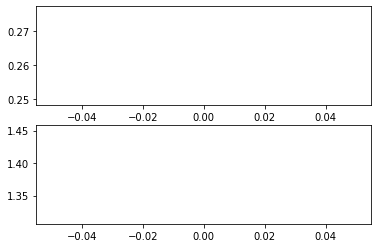

評価データのグラフ


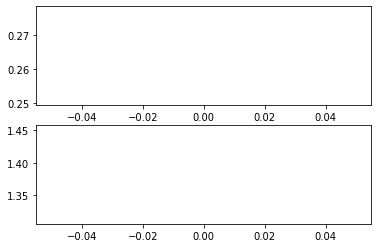

学習データのグラフ


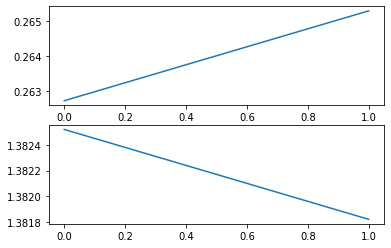

評価データのグラフ


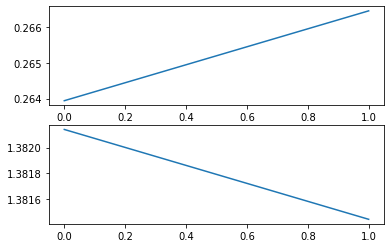

学習データのグラフ


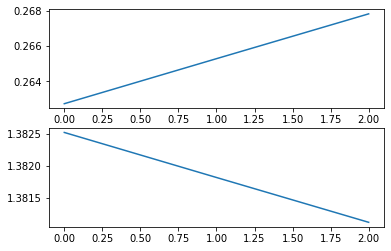

評価データのグラフ


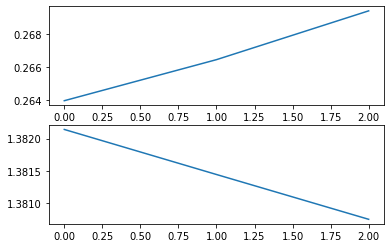

学習データのグラフ


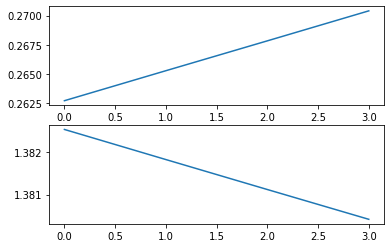

評価データのグラフ


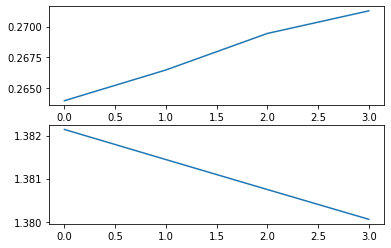

学習データのグラフ


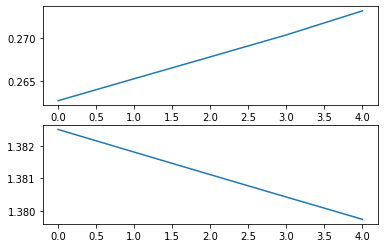

評価データのグラフ


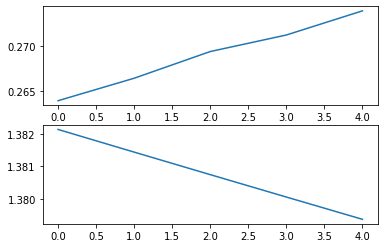

学習データのグラフ


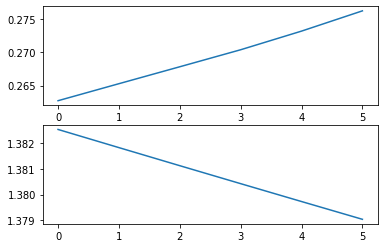

評価データのグラフ


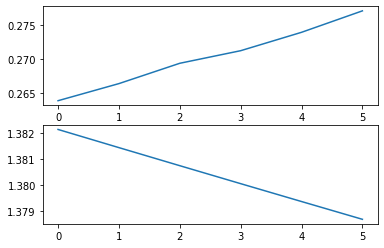

学習データのグラフ


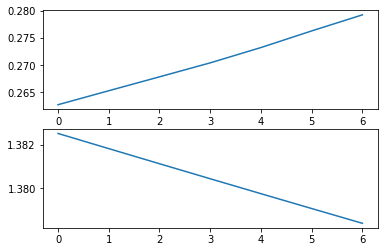

評価データのグラフ


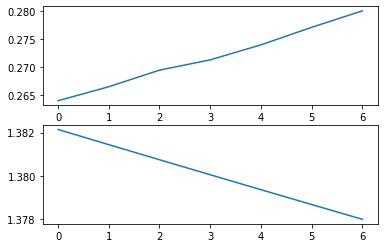

学習データのグラフ


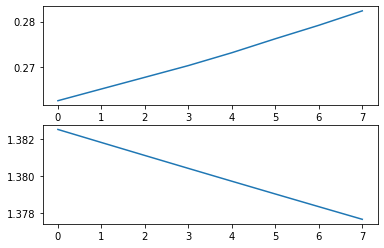

評価データのグラフ


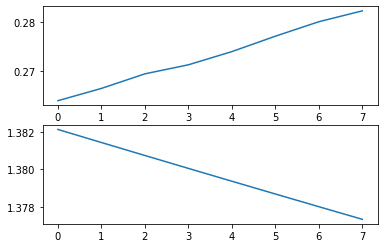

学習データのグラフ


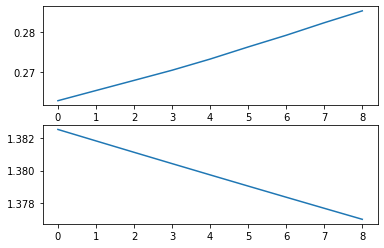

評価データのグラフ


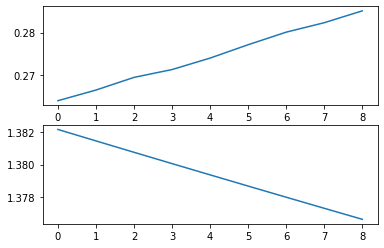

学習データのグラフ


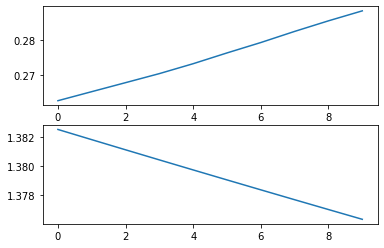

評価データのグラフ


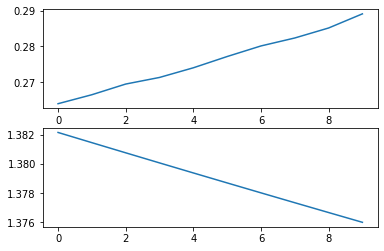

学習データのグラフ


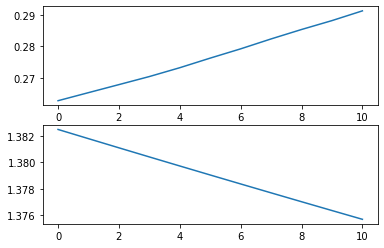

評価データのグラフ


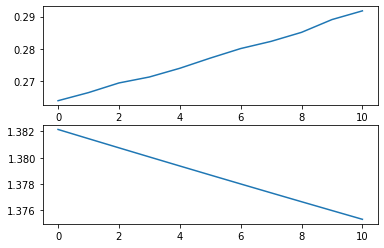

学習データのグラフ


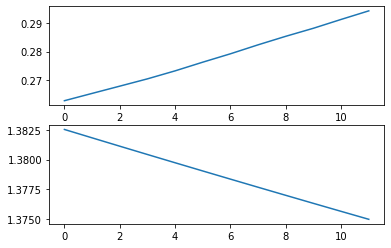

評価データのグラフ


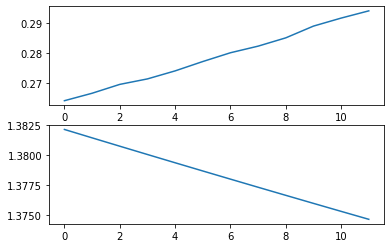

学習データのグラフ


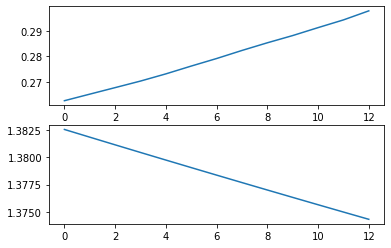

評価データのグラフ


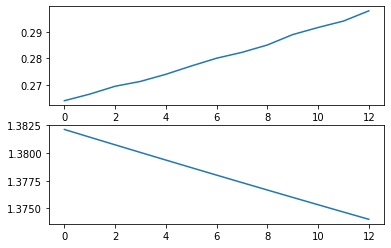

学習データのグラフ


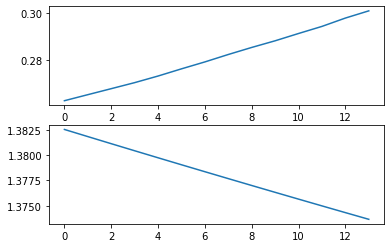

評価データのグラフ


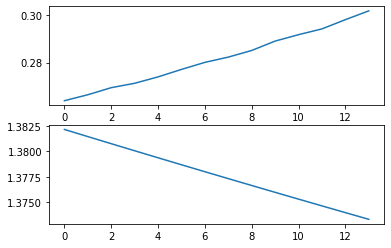

学習データのグラフ


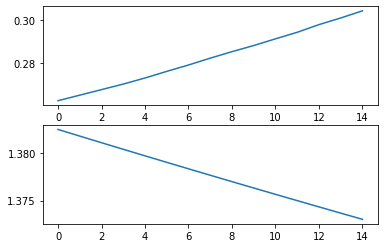

評価データのグラフ


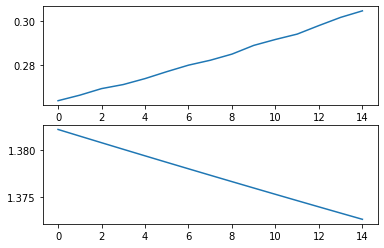

学習データのグラフ


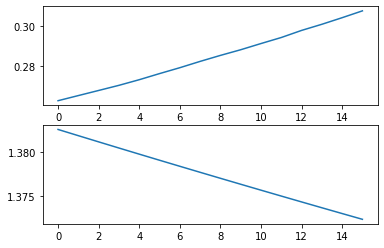

評価データのグラフ


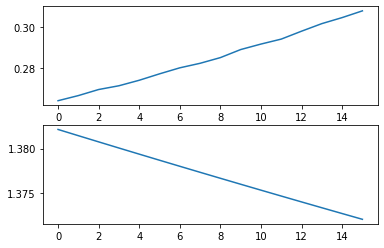

学習データのグラフ


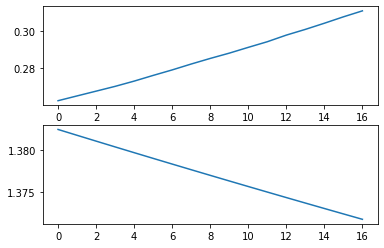

評価データのグラフ


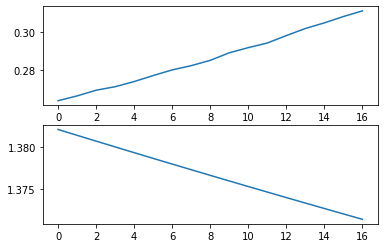

学習データのグラフ


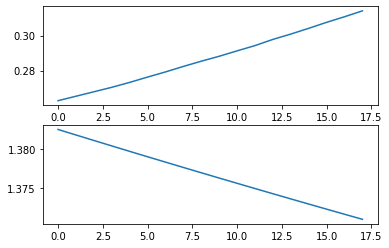

評価データのグラフ


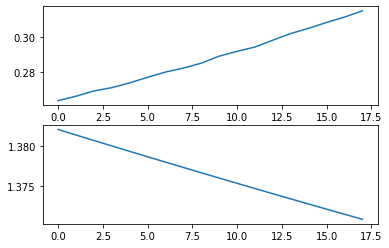

学習データのグラフ


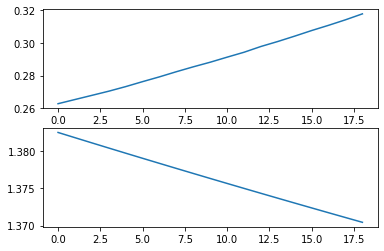

評価データのグラフ


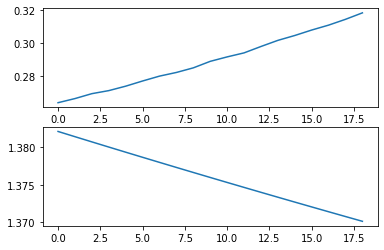

学習データのグラフ


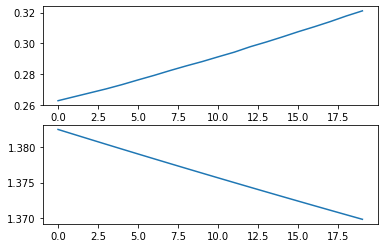

評価データのグラフ


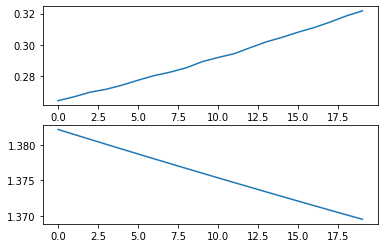

学習データのグラフ


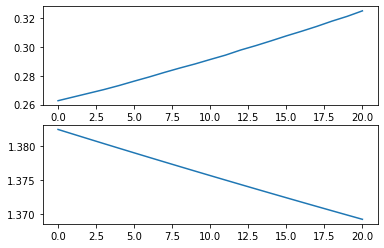

評価データのグラフ


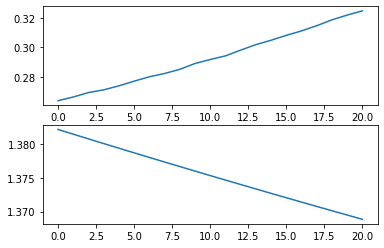

学習データのグラフ


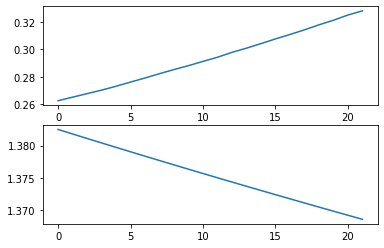

評価データのグラフ


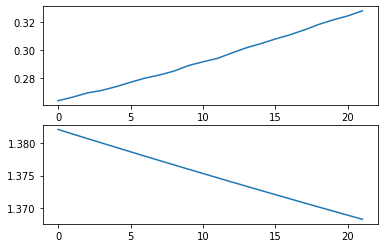

学習データのグラフ


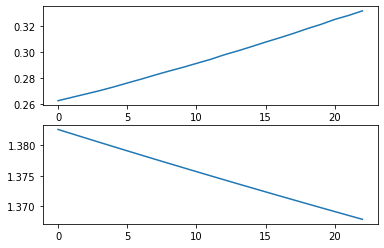

評価データのグラフ


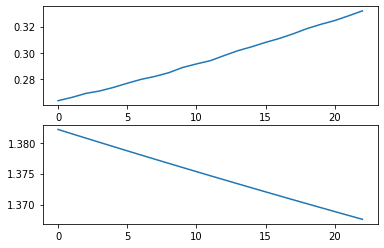

学習データのグラフ


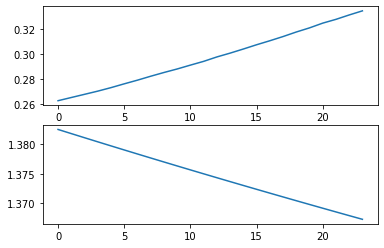

評価データのグラフ


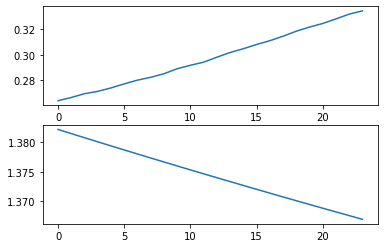

学習データのグラフ


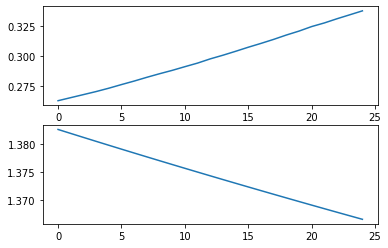

評価データのグラフ


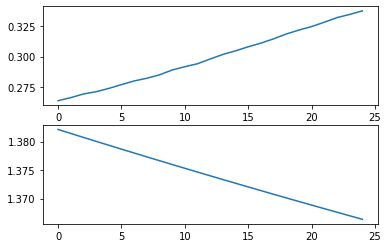

学習データのグラフ


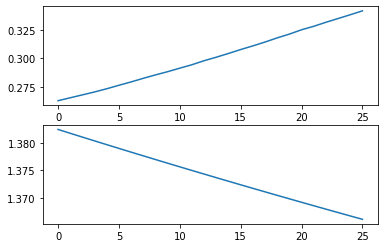

評価データのグラフ


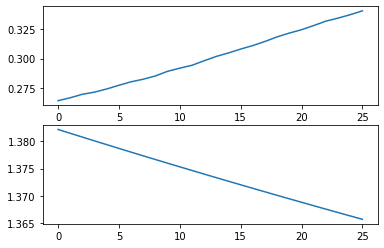

学習データのグラフ


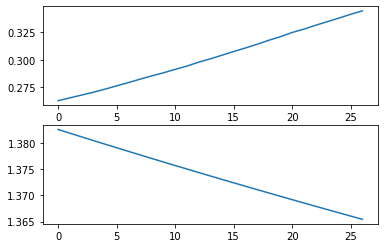

評価データのグラフ


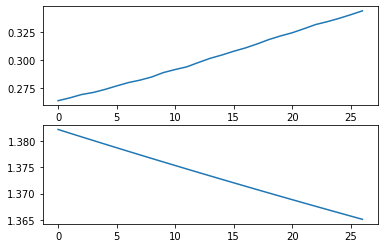

学習データのグラフ


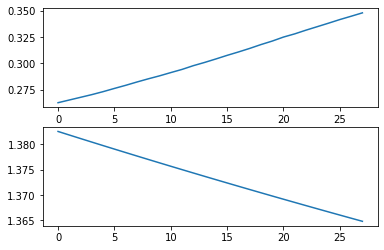

評価データのグラフ


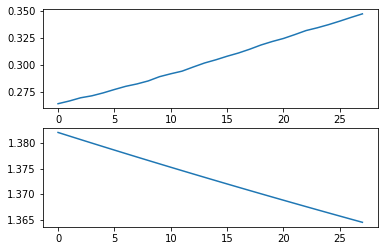

学習データのグラフ


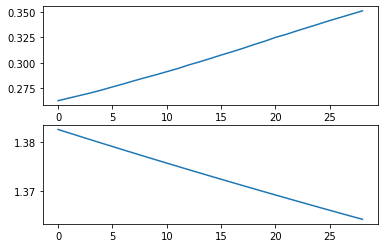

評価データのグラフ


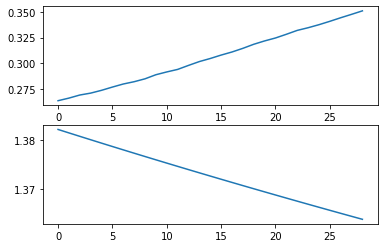

学習データのグラフ


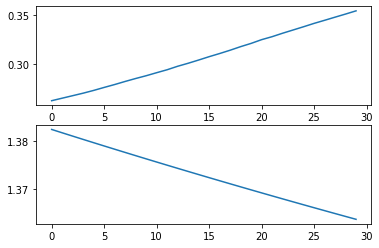

評価データのグラフ


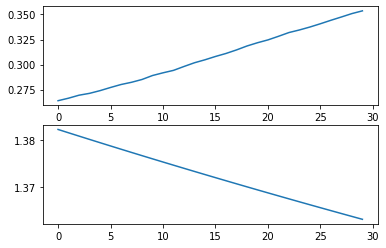

学習データのグラフ


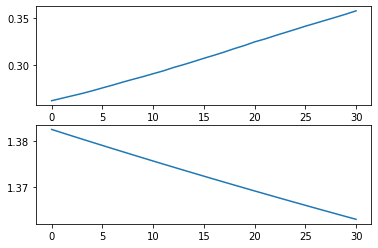

評価データのグラフ


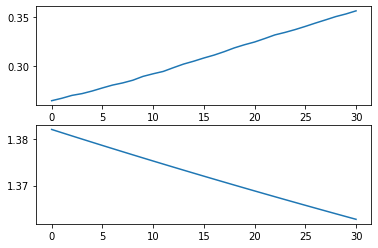

学習データのグラフ


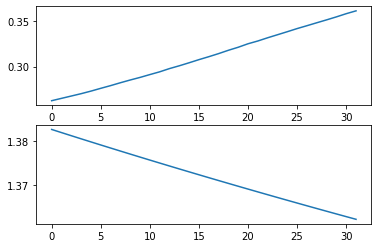

評価データのグラフ


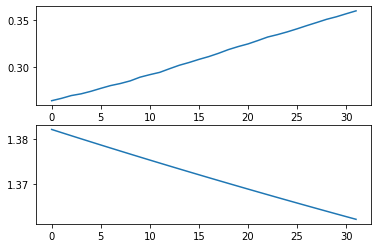

学習データのグラフ


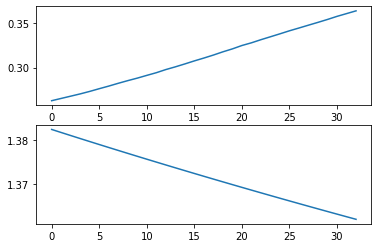

評価データのグラフ


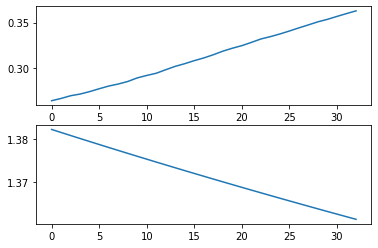

学習データのグラフ


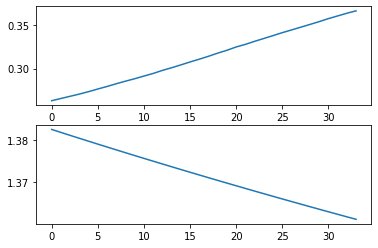

評価データのグラフ


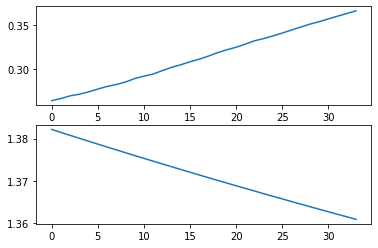

学習データのグラフ


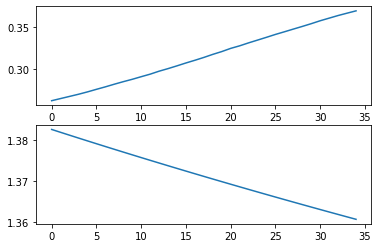

評価データのグラフ


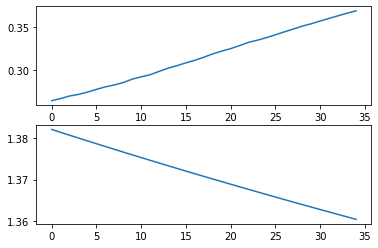

学習データのグラフ


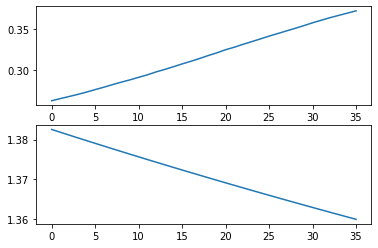

評価データのグラフ


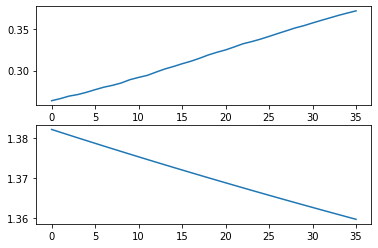

学習データのグラフ


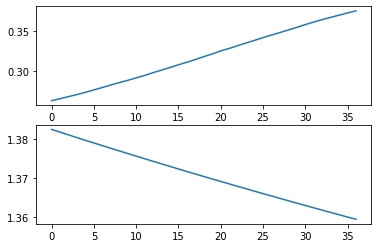

評価データのグラフ


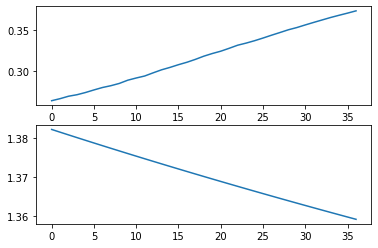

学習データのグラフ


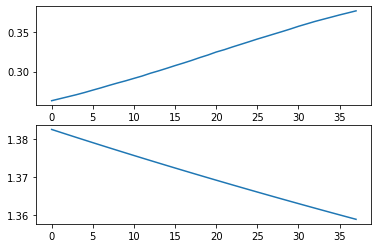

評価データのグラフ


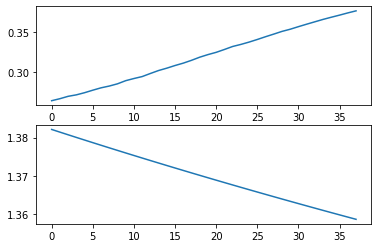

学習データのグラフ


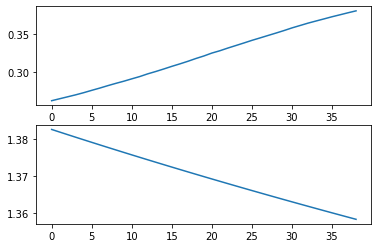

評価データのグラフ


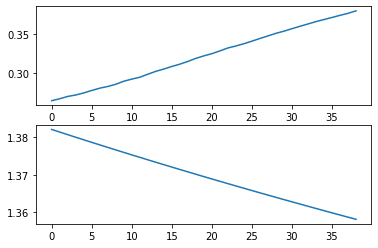

学習データのグラフ


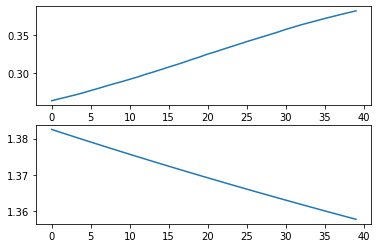

評価データのグラフ


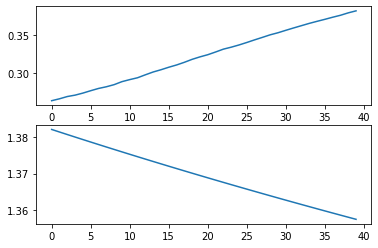

学習データのグラフ


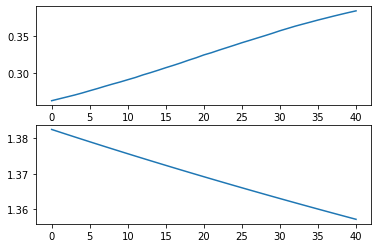

評価データのグラフ


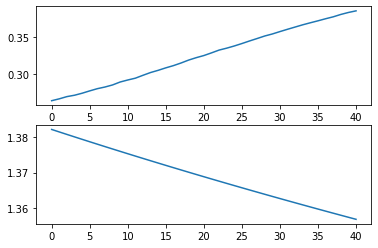

学習データのグラフ


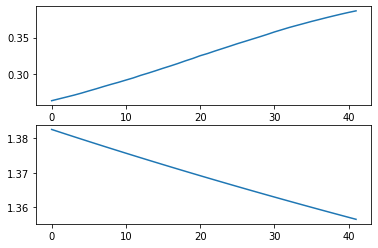

評価データのグラフ


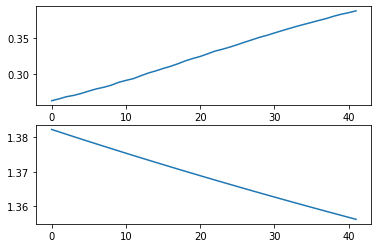

学習データのグラフ


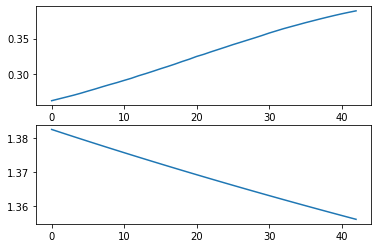

評価データのグラフ


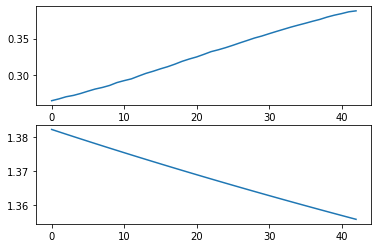

学習データのグラフ


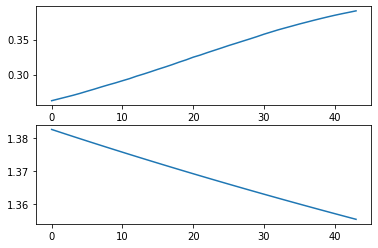

評価データのグラフ


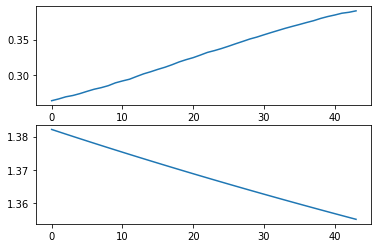

学習データのグラフ


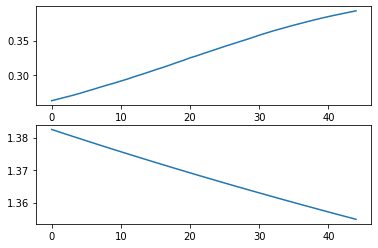

評価データのグラフ


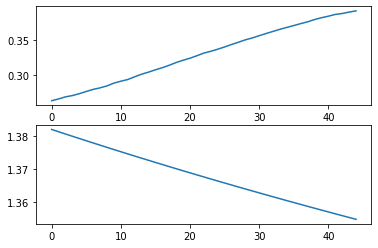

学習データのグラフ


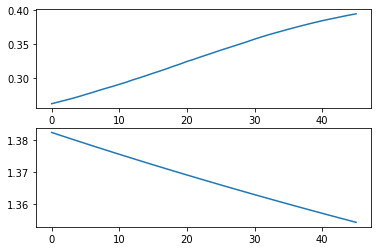

評価データのグラフ


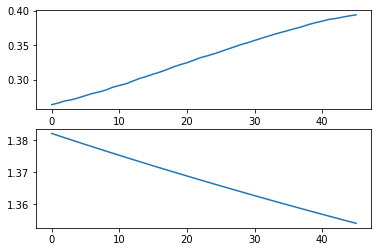

学習データのグラフ


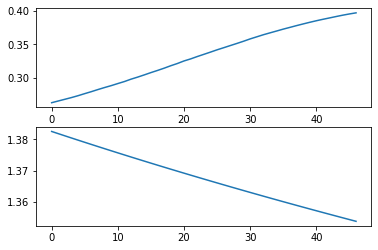

評価データのグラフ


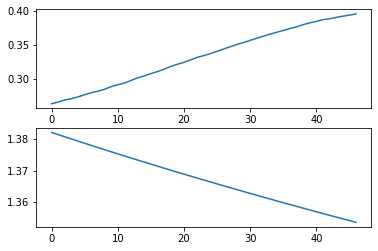

学習データのグラフ


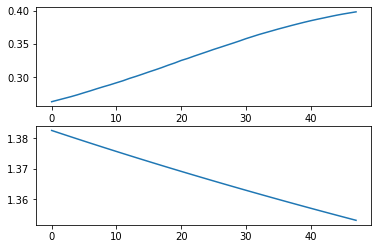

評価データのグラフ


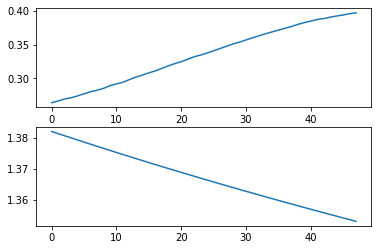

学習データのグラフ


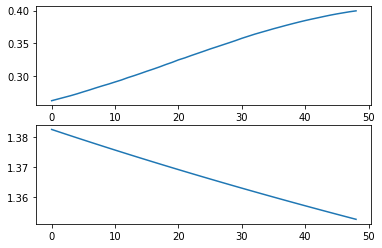

評価データのグラフ


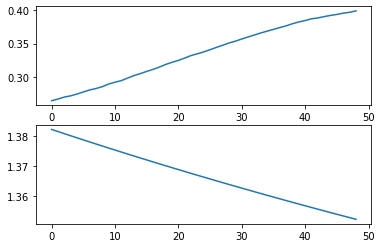

学習データのグラフ


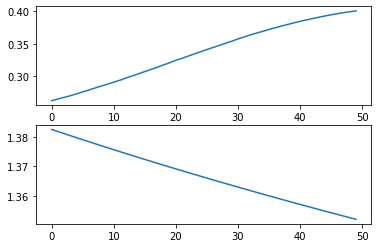

評価データのグラフ


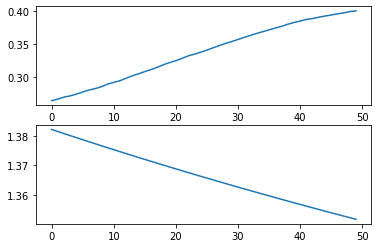

学習データのグラフ


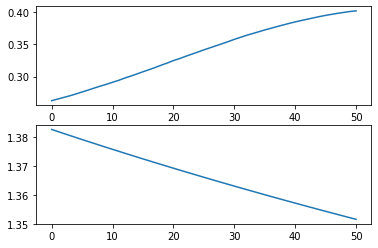

評価データのグラフ


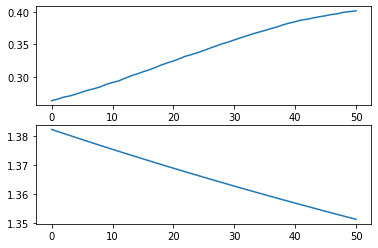

学習データのグラフ


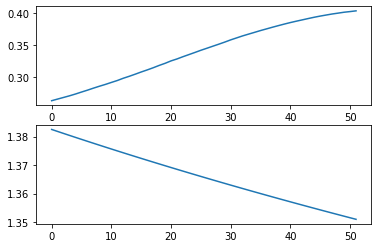

評価データのグラフ


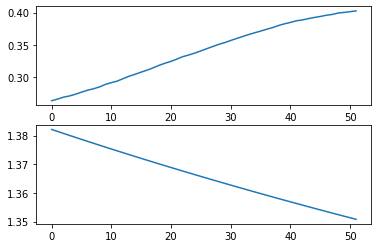

学習データのグラフ


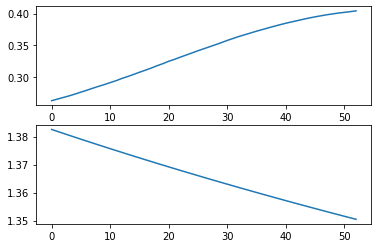

評価データのグラフ


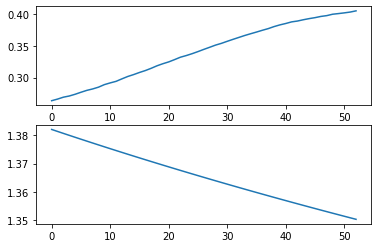

学習データのグラフ


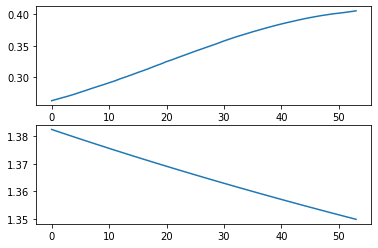

評価データのグラフ


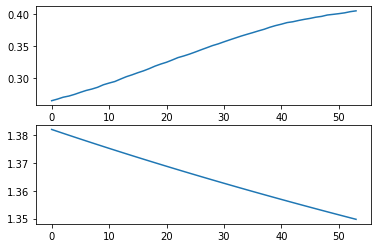

学習データのグラフ


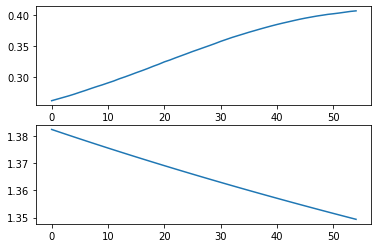

評価データのグラフ


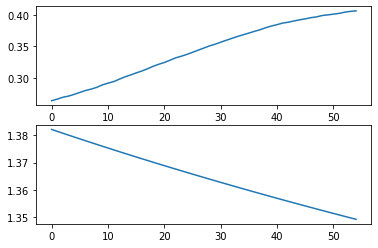

学習データのグラフ


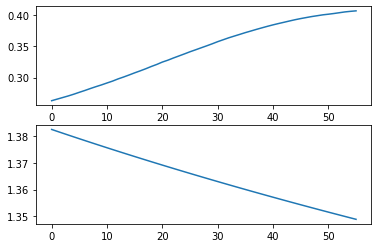

評価データのグラフ


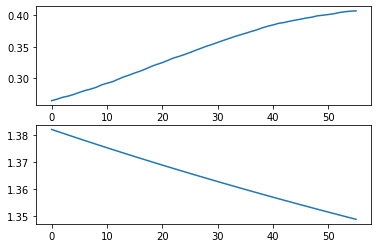

学習データのグラフ


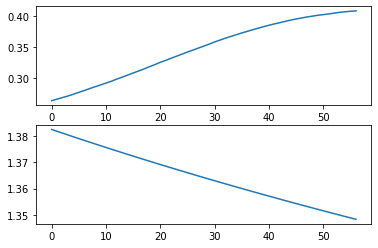

評価データのグラフ


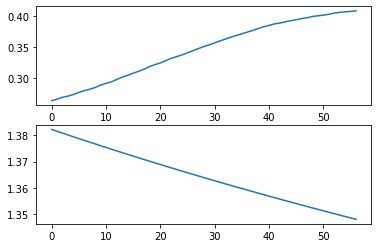

学習データのグラフ


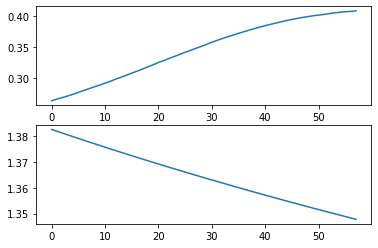

評価データのグラフ


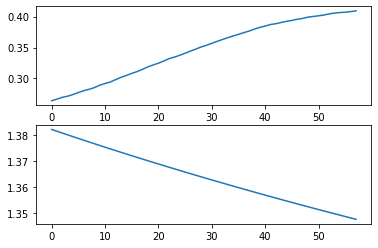

学習データのグラフ


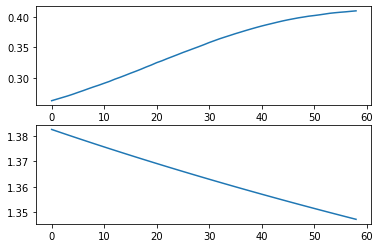

評価データのグラフ


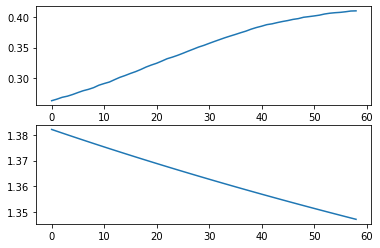

学習データのグラフ


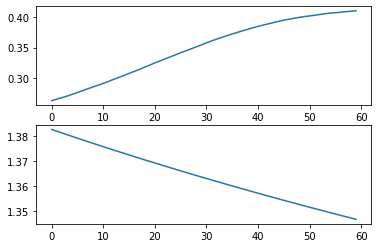

評価データのグラフ


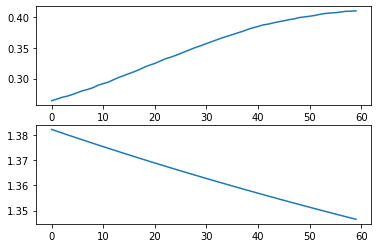

学習データのグラフ


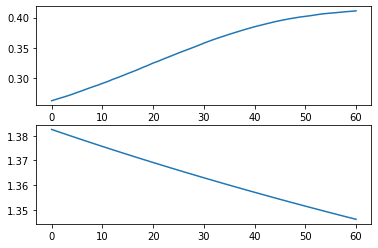

評価データのグラフ


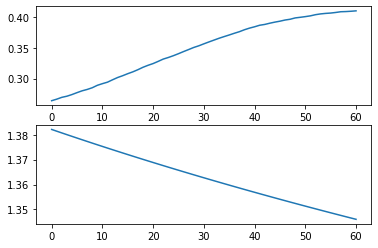

学習データのグラフ


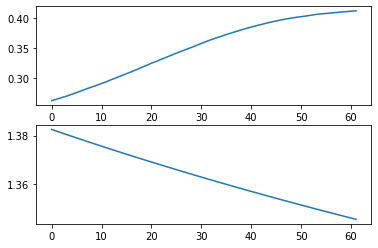

評価データのグラフ


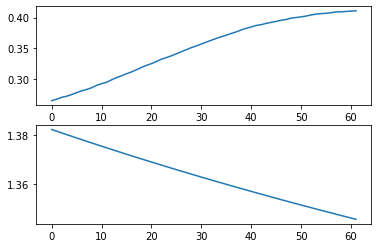

学習データのグラフ


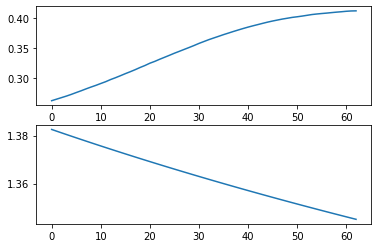

評価データのグラフ


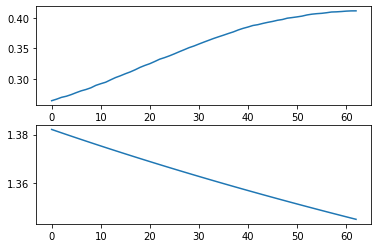

学習データのグラフ


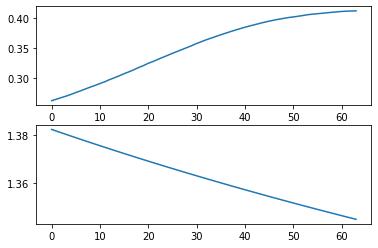

評価データのグラフ


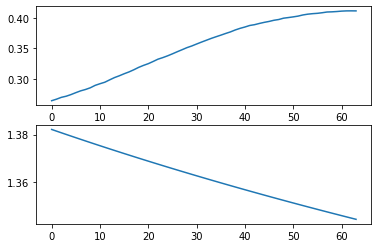

学習データのグラフ


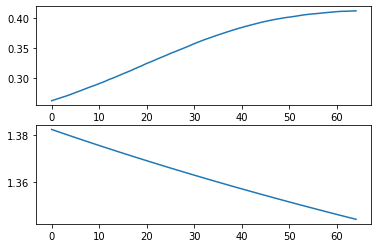

評価データのグラフ


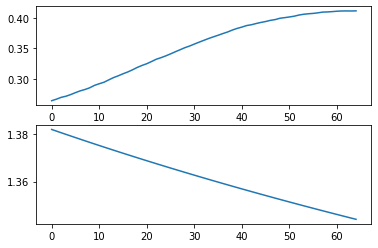

学習データのグラフ


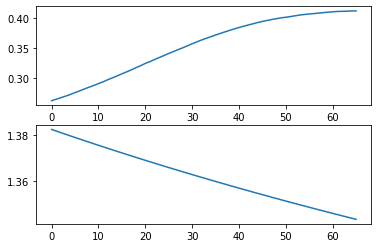

評価データのグラフ


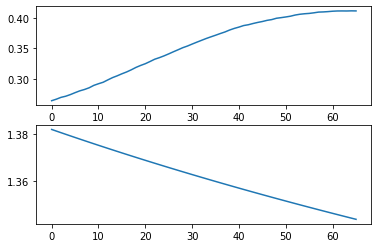

学習データのグラフ


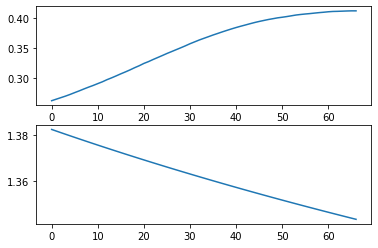

評価データのグラフ


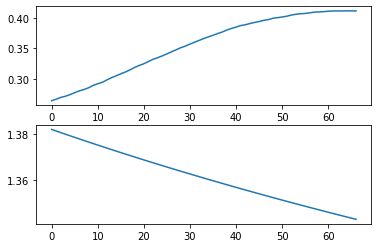

学習データのグラフ


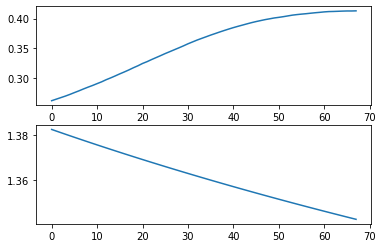

評価データのグラフ


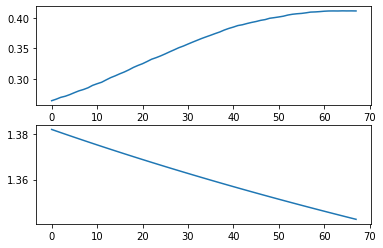

学習データのグラフ


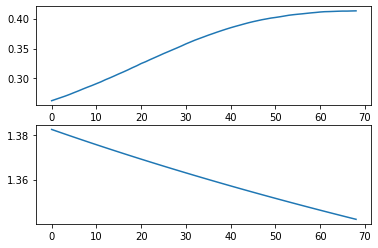

評価データのグラフ


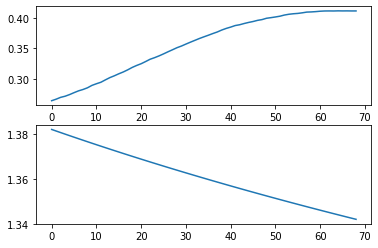

学習データのグラフ


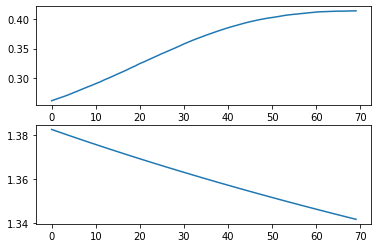

評価データのグラフ


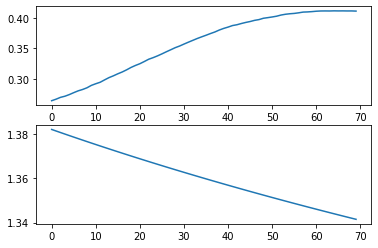

学習データのグラフ


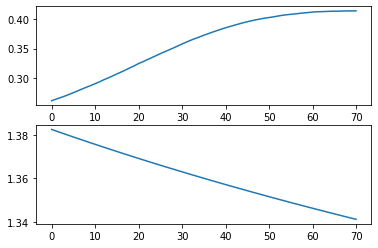

評価データのグラフ


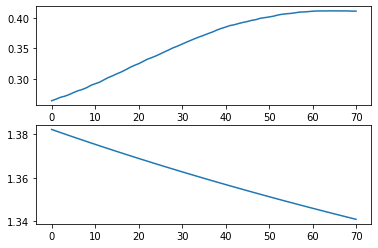

学習データのグラフ


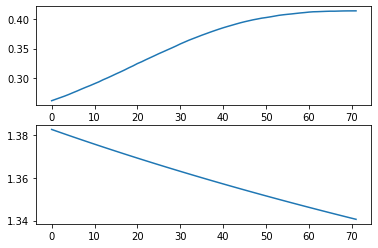

評価データのグラフ


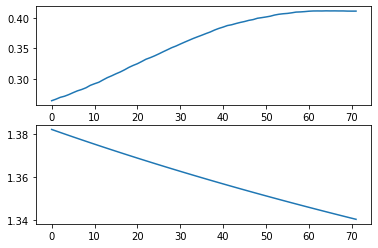

学習データのグラフ


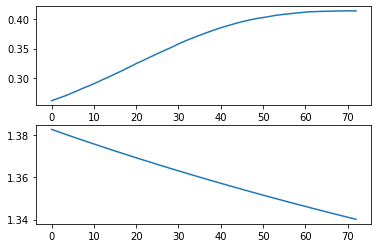

評価データのグラフ


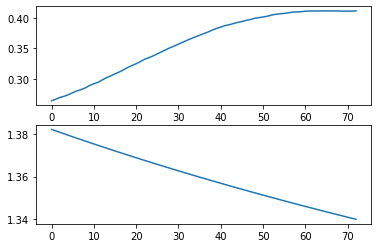

学習データのグラフ


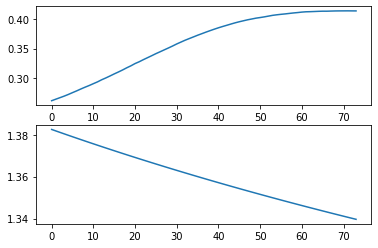

評価データのグラフ


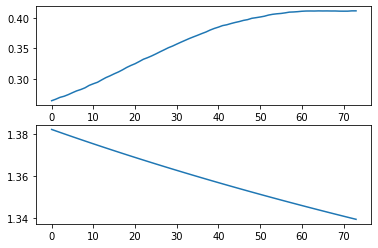

学習データのグラフ


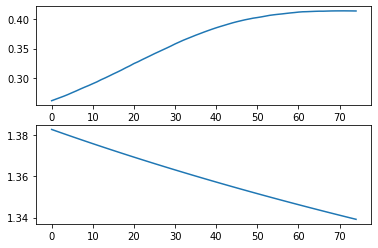

評価データのグラフ


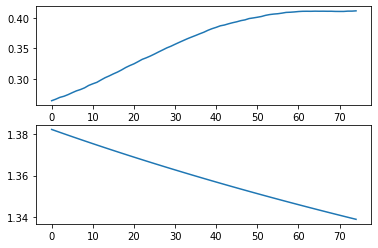

学習データのグラフ


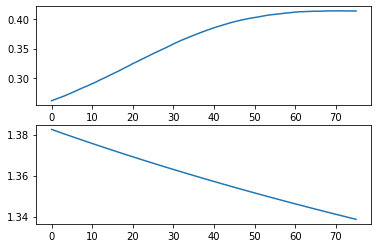

評価データのグラフ


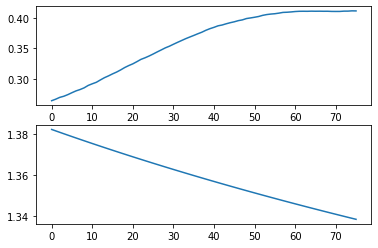

学習データのグラフ


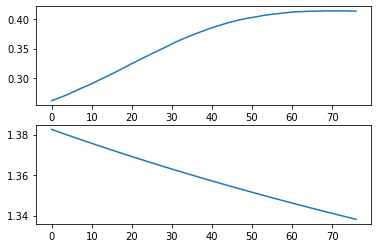

評価データのグラフ


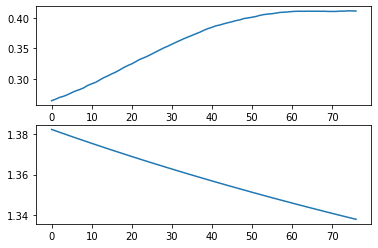

学習データのグラフ


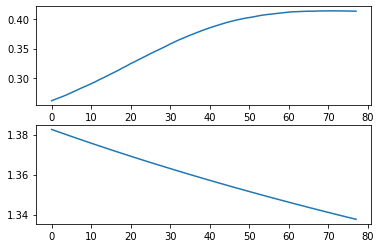

評価データのグラフ


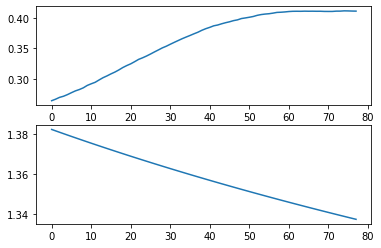

学習データのグラフ


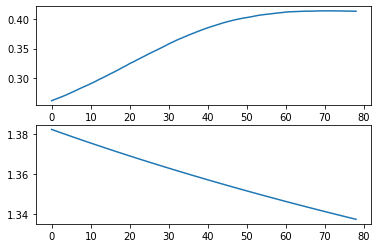

評価データのグラフ


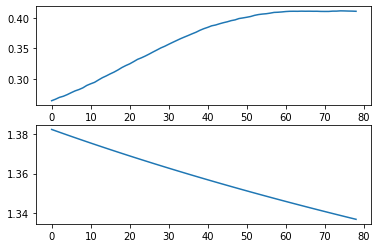

学習データのグラフ


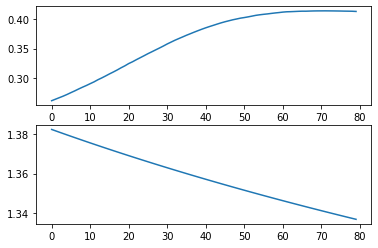

評価データのグラフ


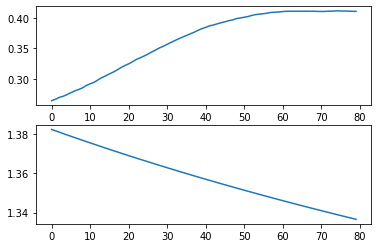

学習データのグラフ


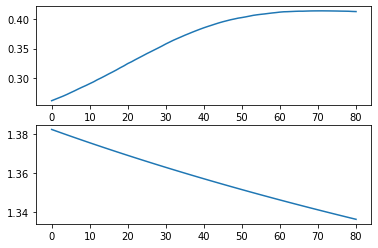

評価データのグラフ


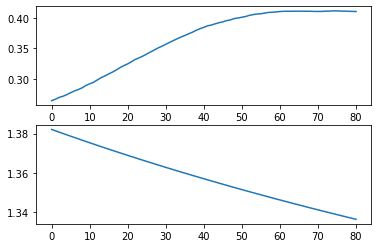

学習データのグラフ


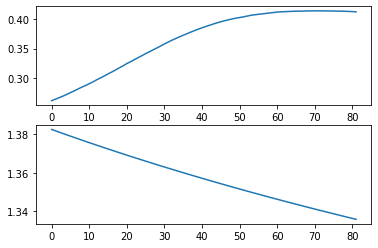

評価データのグラフ


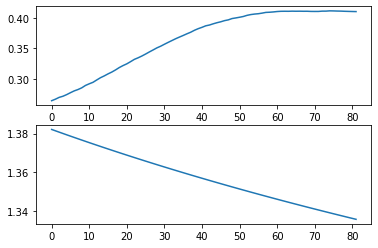

学習データのグラフ


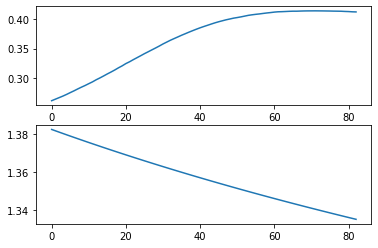

評価データのグラフ


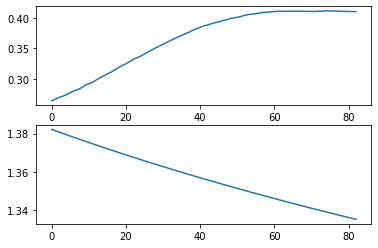

学習データのグラフ


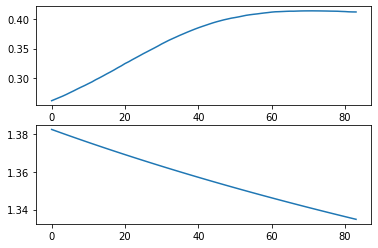

評価データのグラフ


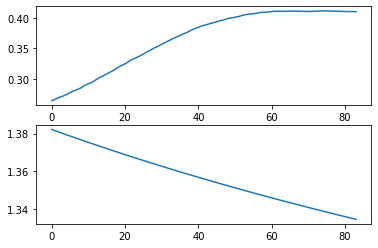

学習データのグラフ


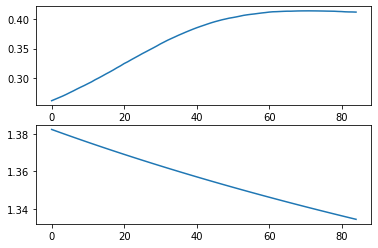

評価データのグラフ


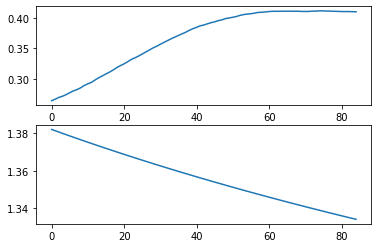

学習データのグラフ


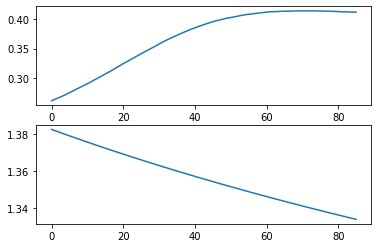

評価データのグラフ


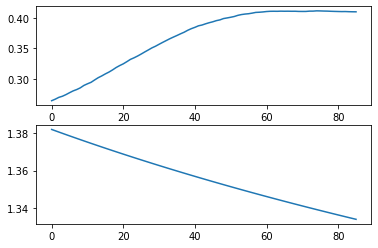

学習データのグラフ


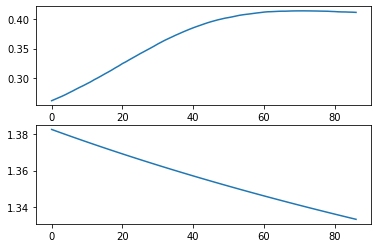

評価データのグラフ


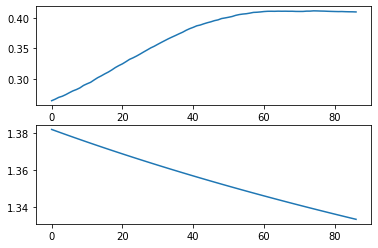

学習データのグラフ


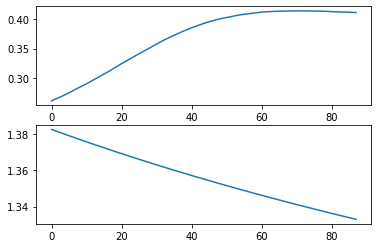

評価データのグラフ


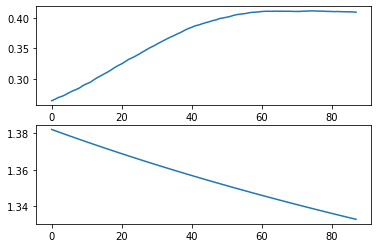

学習データのグラフ


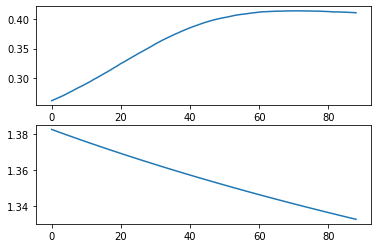

評価データのグラフ


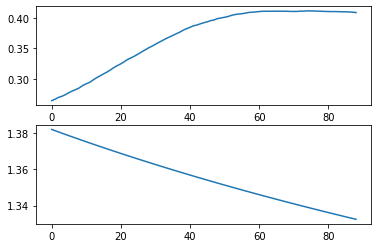

学習データのグラフ


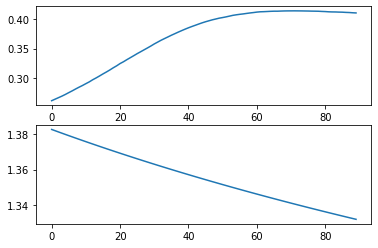

評価データのグラフ


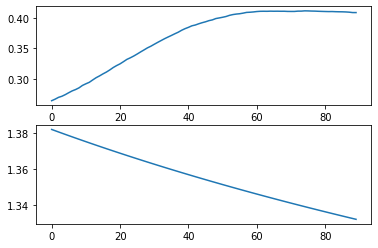

学習データのグラフ


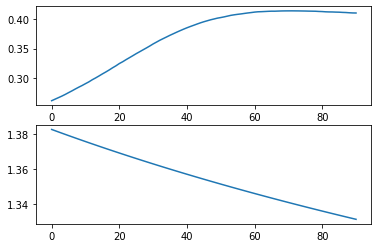

評価データのグラフ


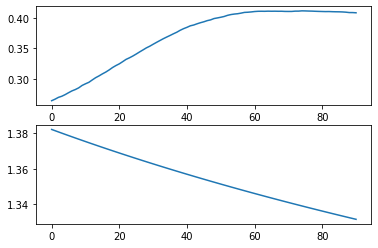

学習データのグラフ


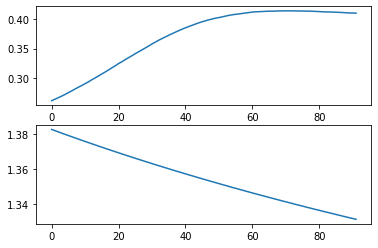

評価データのグラフ


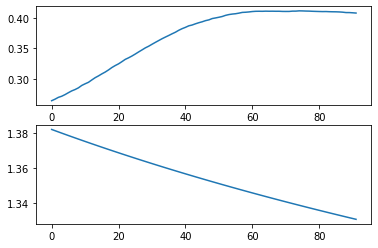

学習データのグラフ


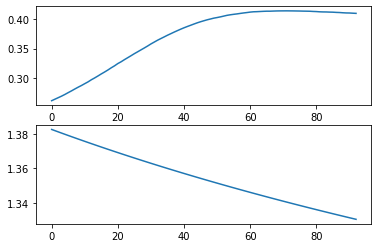

評価データのグラフ


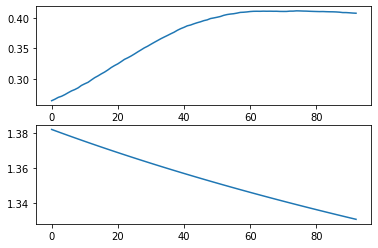

学習データのグラフ


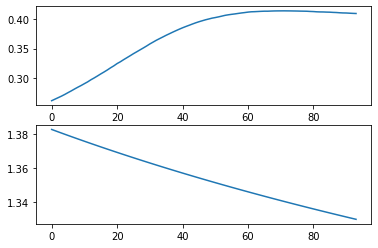

評価データのグラフ


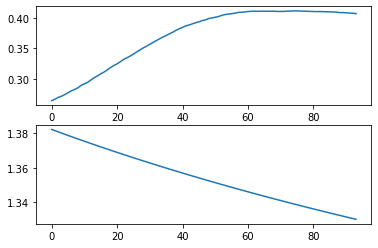

学習データのグラフ


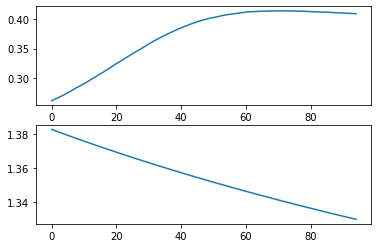

評価データのグラフ


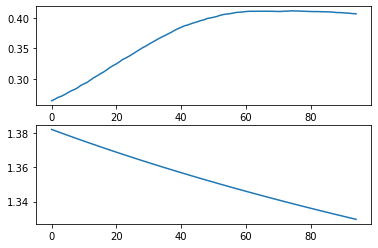

学習データのグラフ


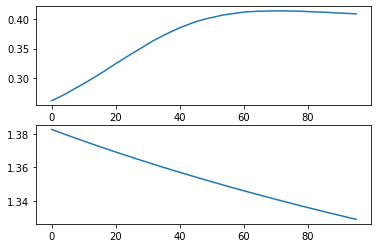

評価データのグラフ


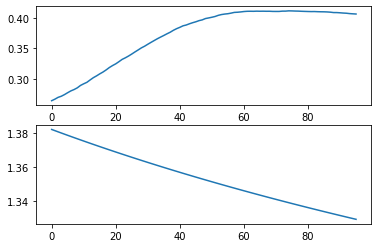

学習データのグラフ


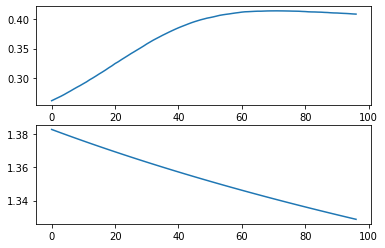

評価データのグラフ


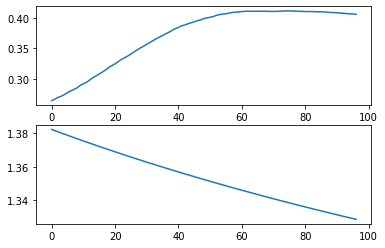

学習データのグラフ


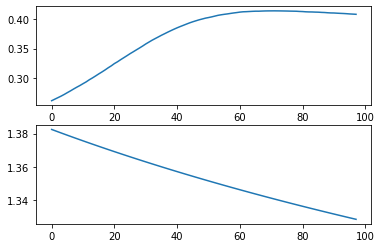

評価データのグラフ


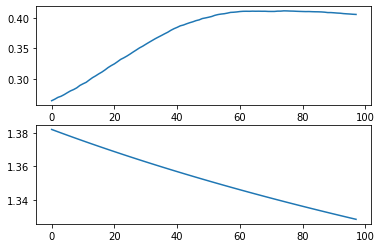

学習データのグラフ


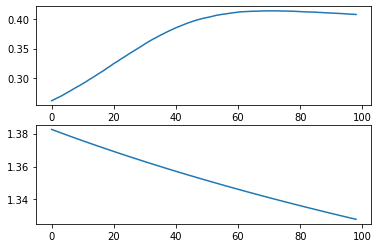

評価データのグラフ


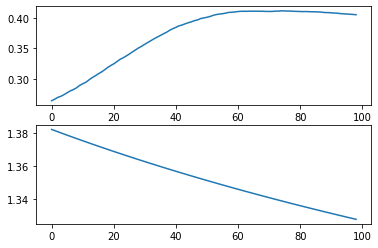

学習データのグラフ


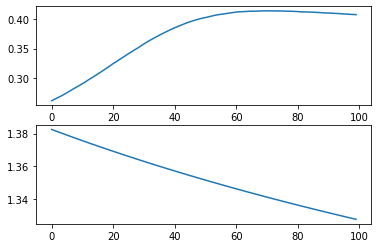

評価データのグラフ


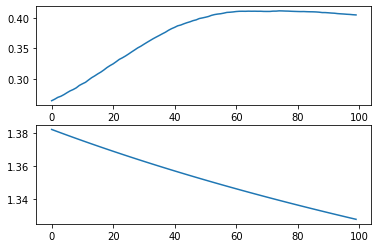

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
max_epoch = 100
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.int64)
x_val_torch = torch.tensor(x_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.int64)

loses = []
accs = []
val_loses = []
val_accs = []

for epoch in range(max_epoch):

        # データをGPUへ転送
        x = x_train_torch
        t = y_train_torch

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 学習状況の確認
        label = torch.argmax(y, dim=1)
        acc = (label == t).sum() * 1.0 / len(t)
        loses.append(loss.item())
        accs.append(acc)
        print("学習データのグラフ")
        graph_plot(accs, loses, epoch+1)


        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5

        #評価データ
        x_valid = x_val_torch
        t_valid = y_val_torch
        y_valid = net(x_valid)
        val_label = torch.argmax(y_valid, dim=1)  
        val_acc = (val_label == t_valid).sum() * 1.0 / len(t_valid)   

        val_loss = criterion(y_valid, t_valid)
        val_accs.append(val_acc)
        val_loses.append(val_loss.item())
        print("評価データのグラフ")
        graph_plot(val_accs, val_loses, epoch+1)


76

学習データのグラフ


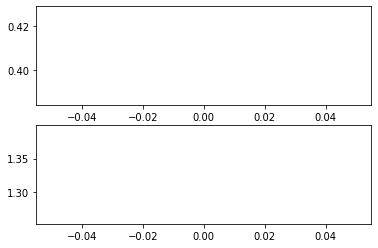

評価データのグラフ


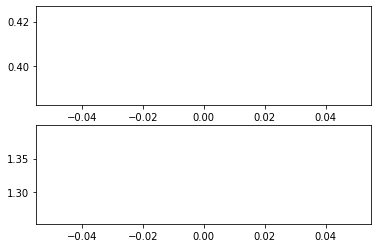

学習データのグラフ


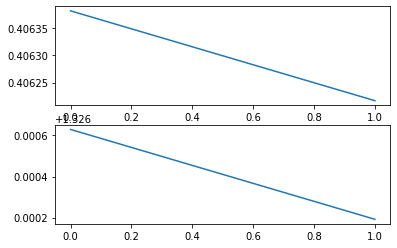

評価データのグラフ


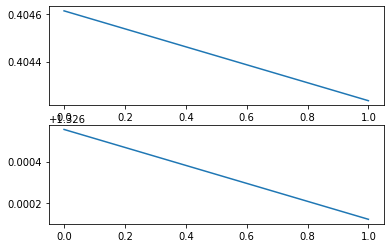

学習データのグラフ


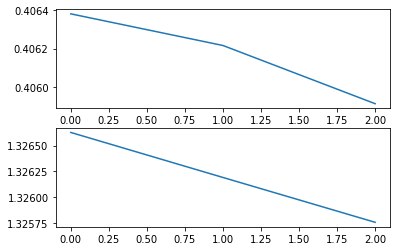

評価データのグラフ


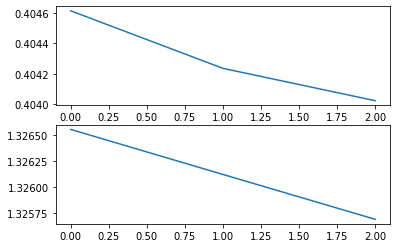

学習データのグラフ


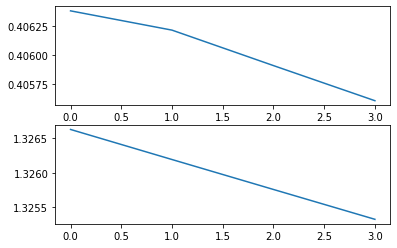

評価データのグラフ


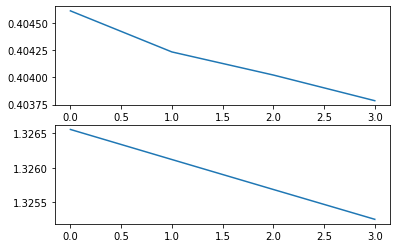

学習データのグラフ


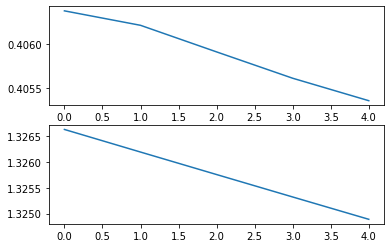

評価データのグラフ


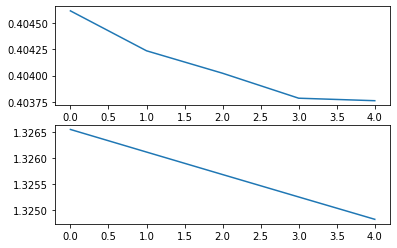

学習データのグラフ


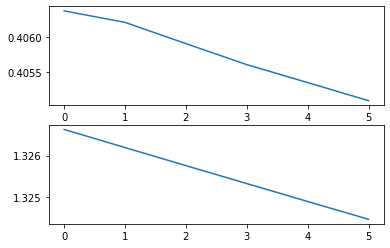

評価データのグラフ


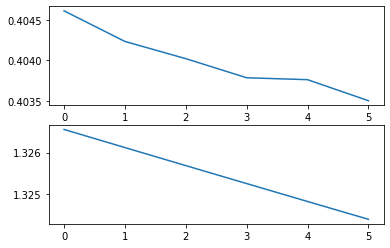

学習データのグラフ


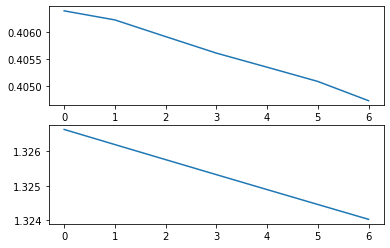

評価データのグラフ


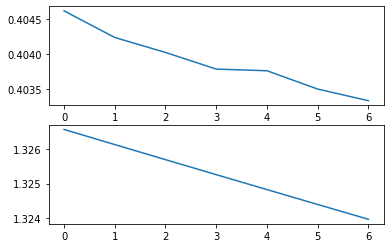

学習データのグラフ


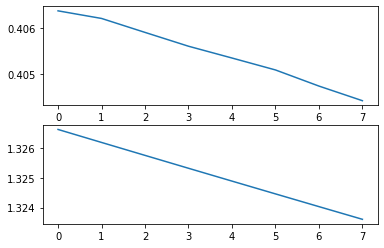

評価データのグラフ


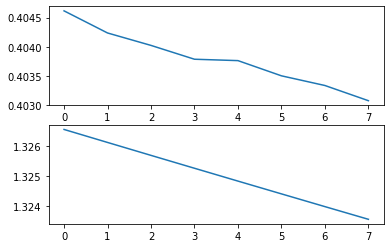

学習データのグラフ


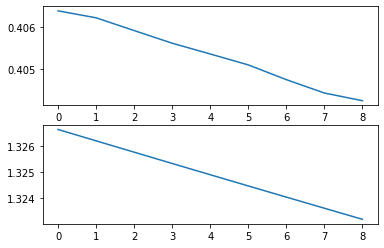

評価データのグラフ


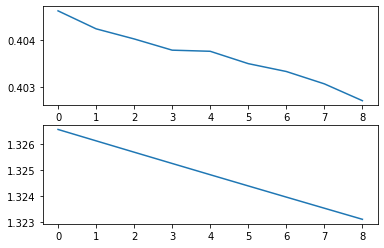

学習データのグラフ


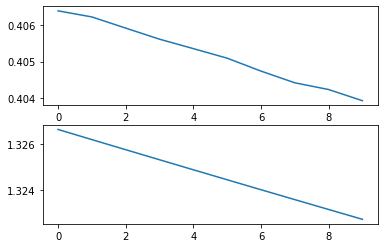

評価データのグラフ


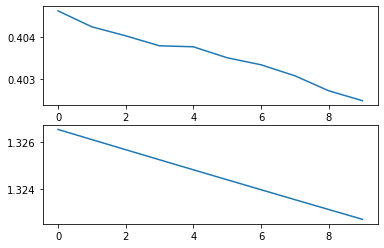

学習データのグラフ


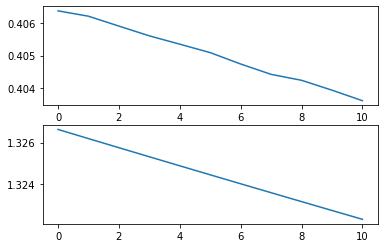

評価データのグラフ


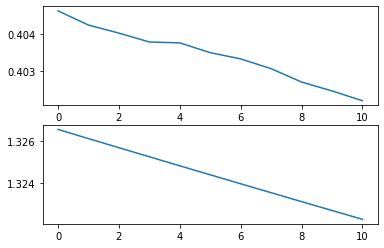

学習データのグラフ


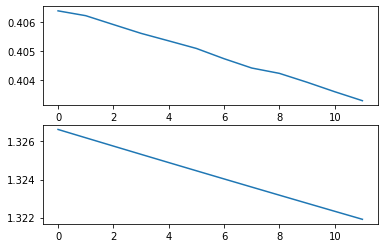

評価データのグラフ


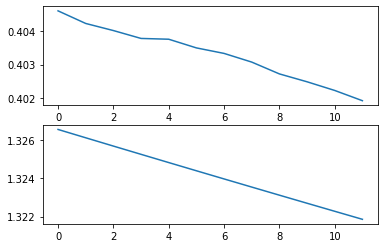

学習データのグラフ


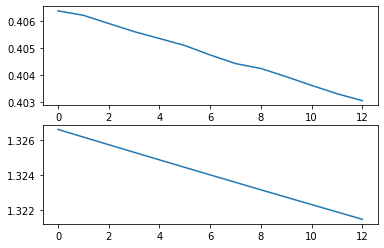

評価データのグラフ


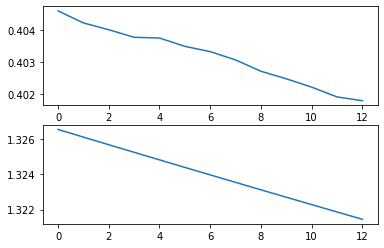

学習データのグラフ


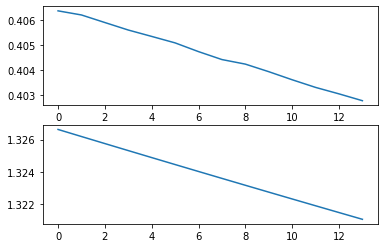

評価データのグラフ


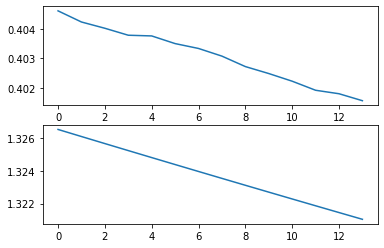

学習データのグラフ


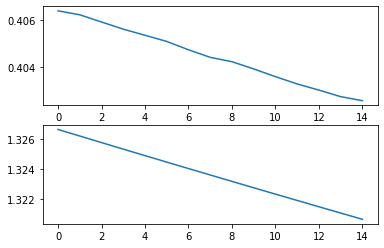

評価データのグラフ


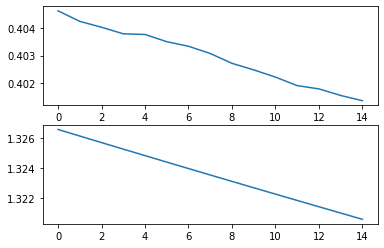

学習データのグラフ


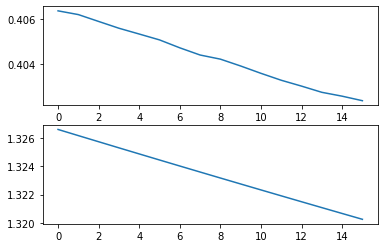

評価データのグラフ


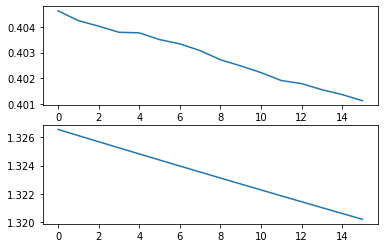

学習データのグラフ


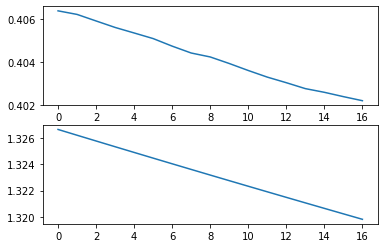

評価データのグラフ


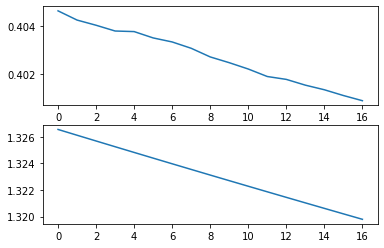

学習データのグラフ


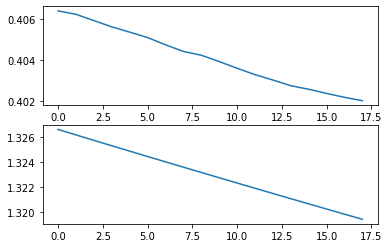

評価データのグラフ


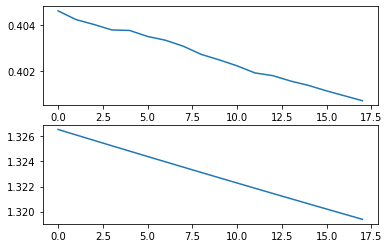

学習データのグラフ


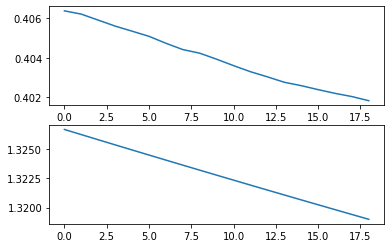

評価データのグラフ


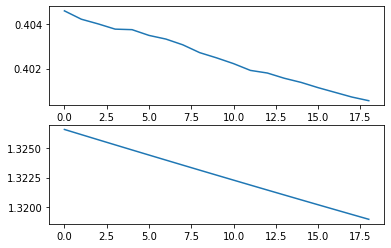

学習データのグラフ


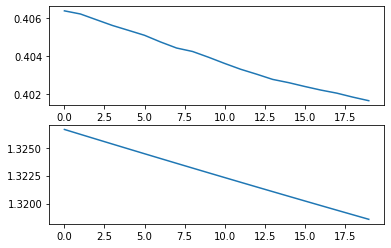

評価データのグラフ


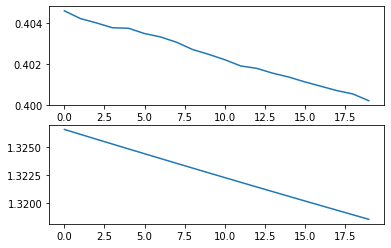

学習データのグラフ


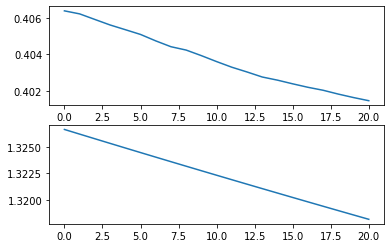

評価データのグラフ


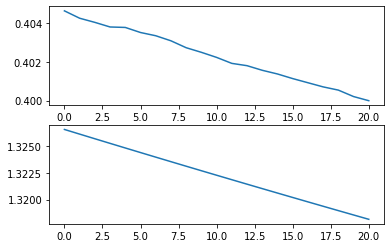

学習データのグラフ


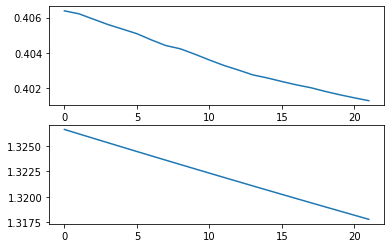

評価データのグラフ


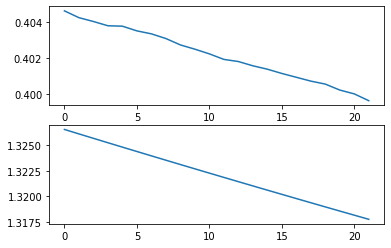

学習データのグラフ


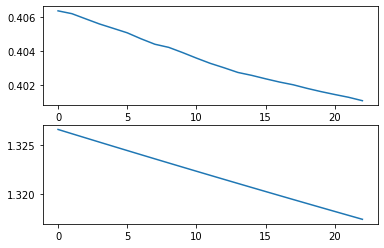

評価データのグラフ


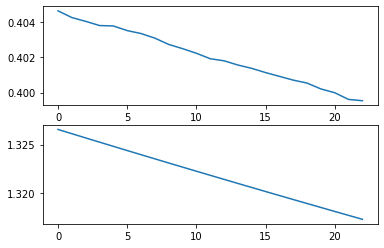

学習データのグラフ


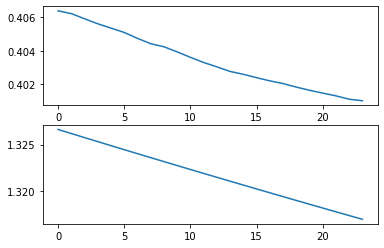

評価データのグラフ


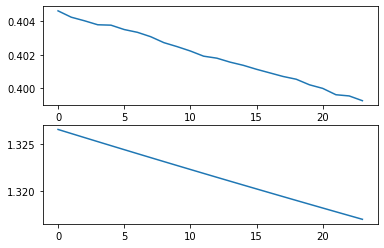

学習データのグラフ


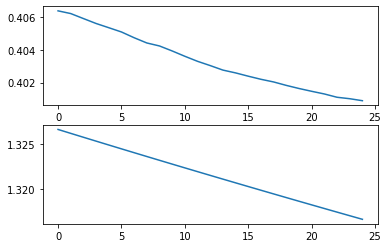

評価データのグラフ


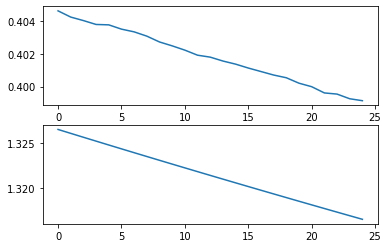

学習データのグラフ


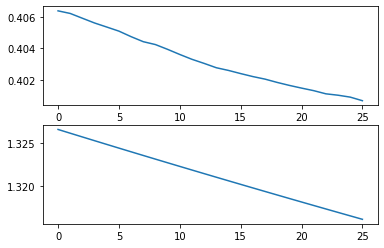

評価データのグラフ


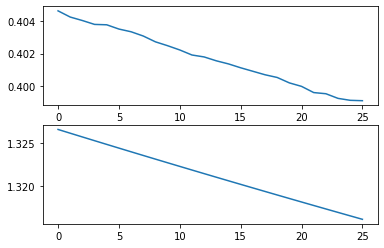

学習データのグラフ


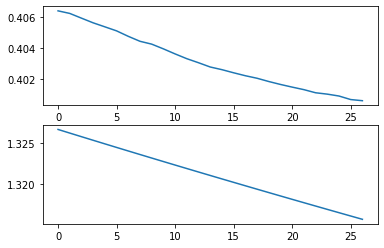

評価データのグラフ


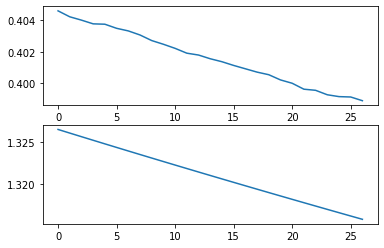

学習データのグラフ


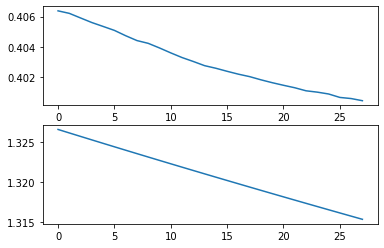

評価データのグラフ


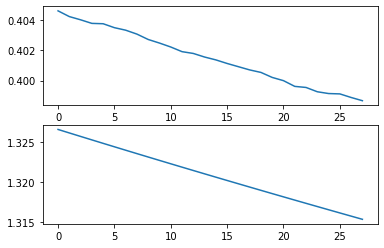

学習データのグラフ


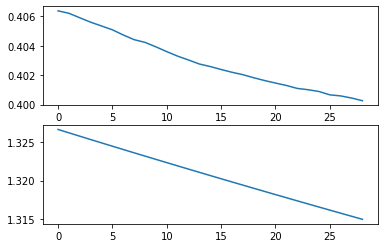

評価データのグラフ


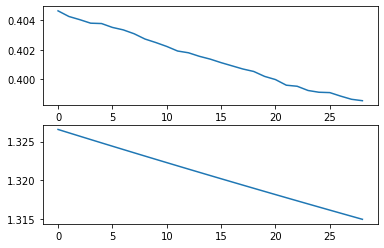

学習データのグラフ


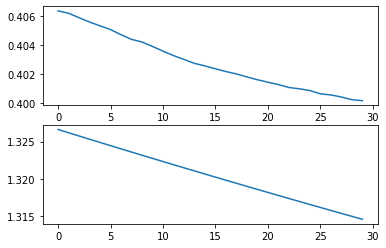

評価データのグラフ


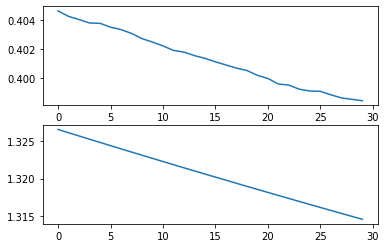

学習データのグラフ


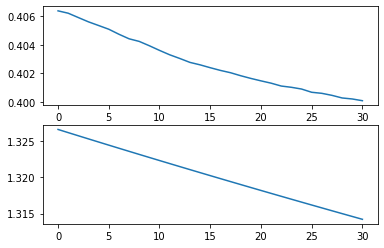

評価データのグラフ


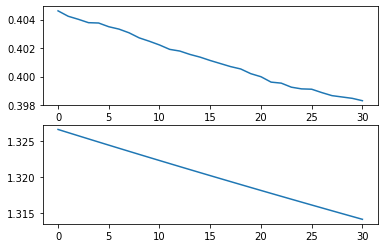

学習データのグラフ


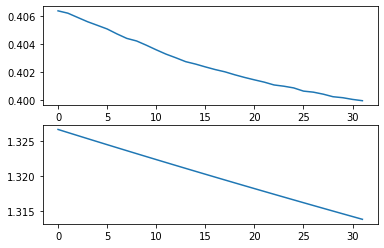

評価データのグラフ


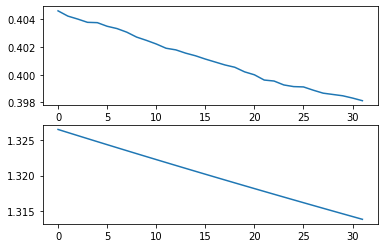

学習データのグラフ


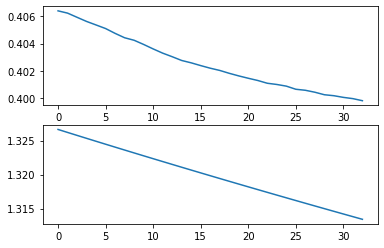

評価データのグラフ


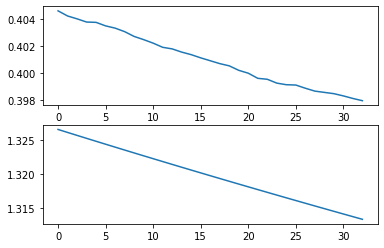

学習データのグラフ


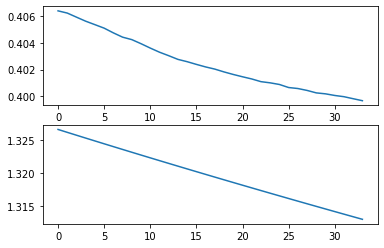

評価データのグラフ


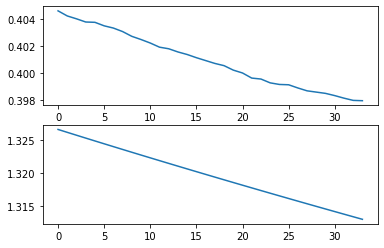

学習データのグラフ


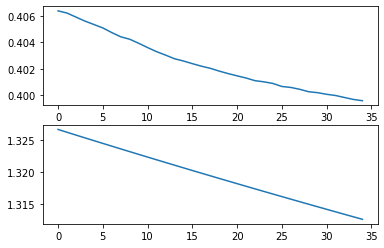

評価データのグラフ


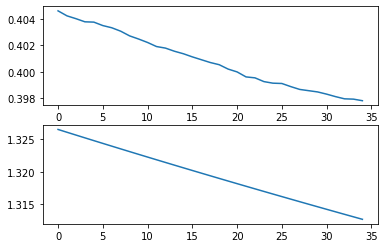

学習データのグラフ


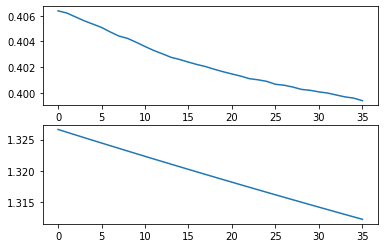

評価データのグラフ


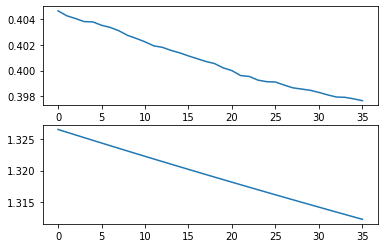

学習データのグラフ


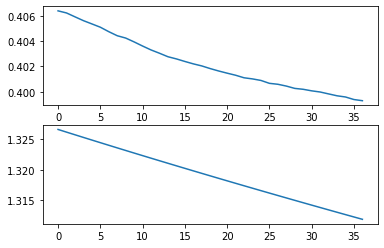

評価データのグラフ


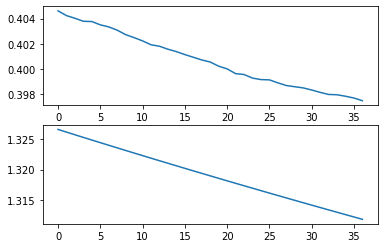

学習データのグラフ


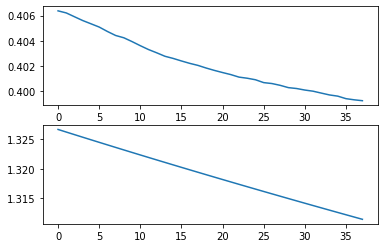

評価データのグラフ


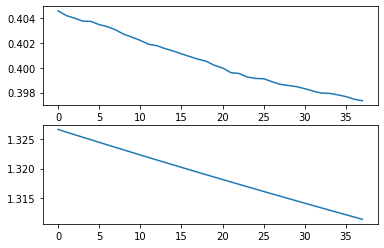

学習データのグラフ


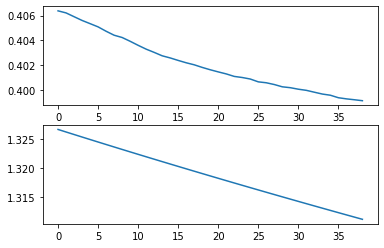

評価データのグラフ


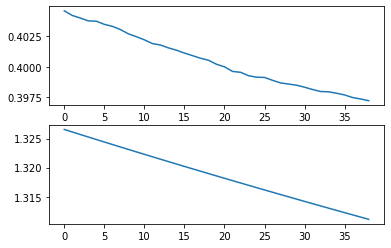

学習データのグラフ


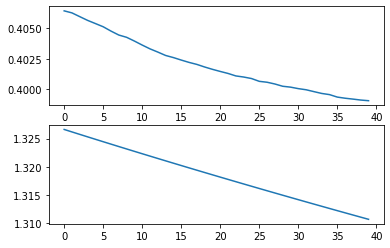

評価データのグラフ


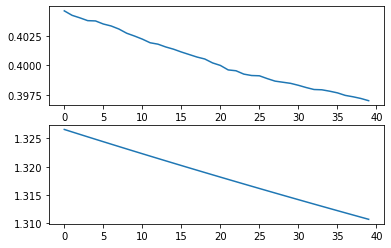

学習データのグラフ


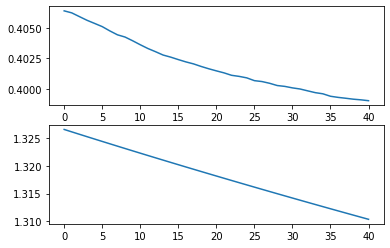

評価データのグラフ


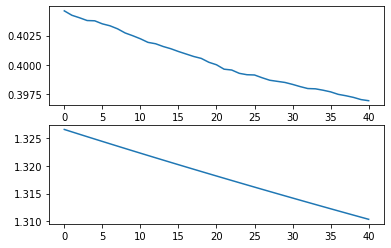

学習データのグラフ


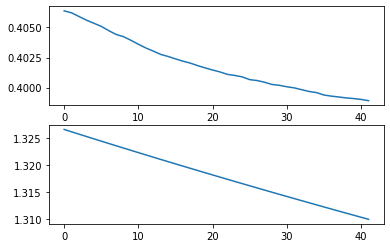

評価データのグラフ


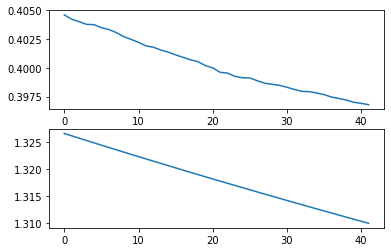

学習データのグラフ


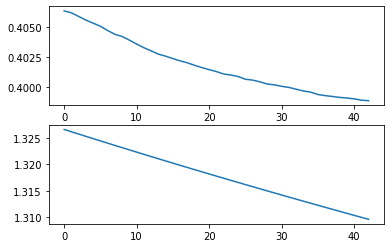

評価データのグラフ


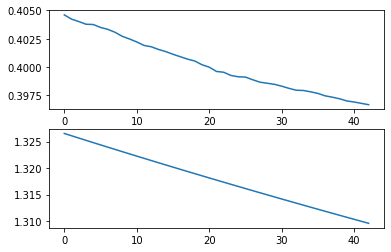

学習データのグラフ


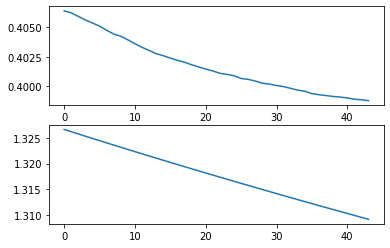

評価データのグラフ


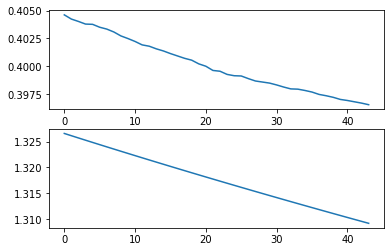

学習データのグラフ


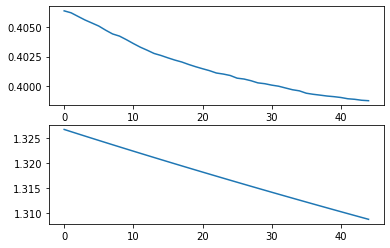

評価データのグラフ


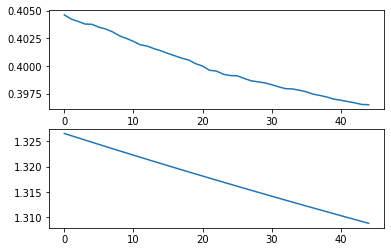

学習データのグラフ


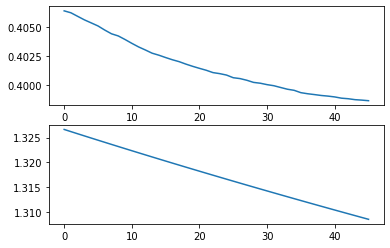

評価データのグラフ


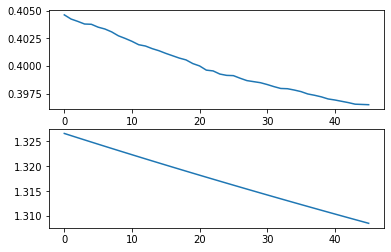

学習データのグラフ


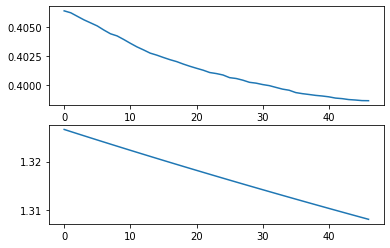

評価データのグラフ


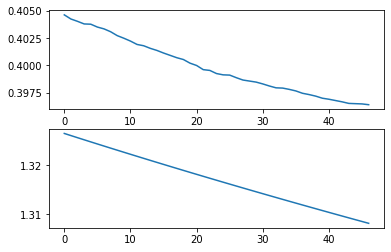

学習データのグラフ


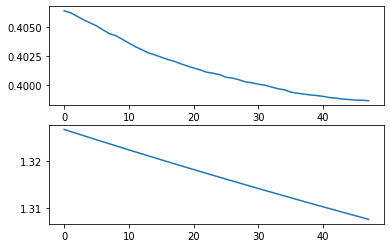

評価データのグラフ


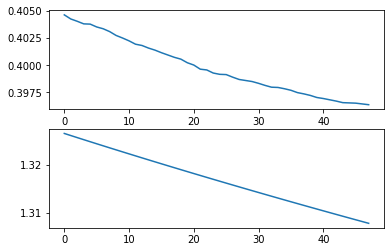

学習データのグラフ


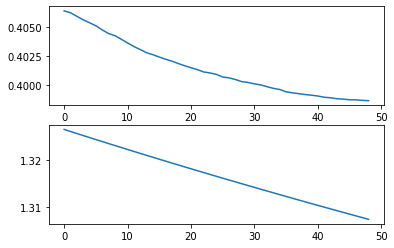

評価データのグラフ


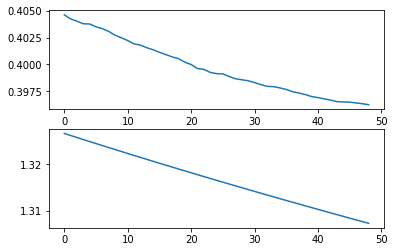

学習データのグラフ


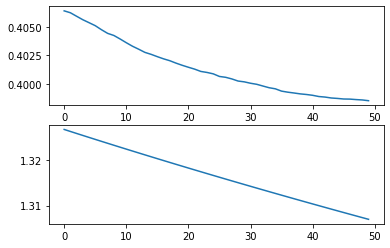

評価データのグラフ


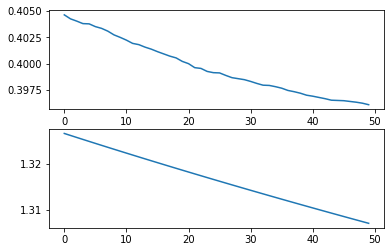

学習データのグラフ


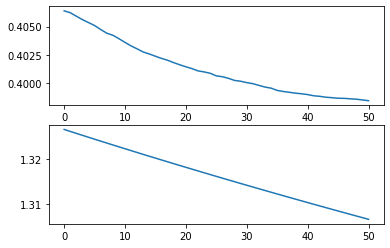

評価データのグラフ


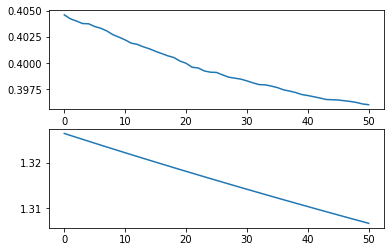

学習データのグラフ


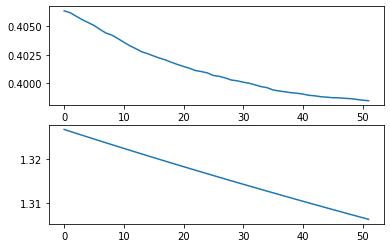

評価データのグラフ


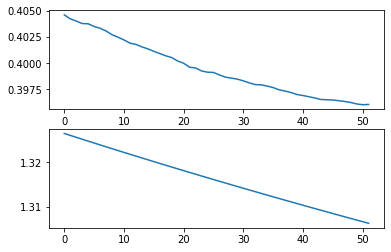

学習データのグラフ


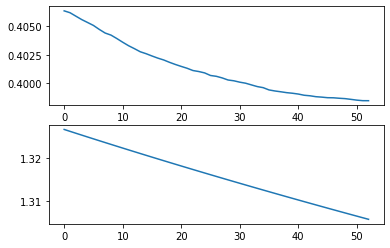

評価データのグラフ


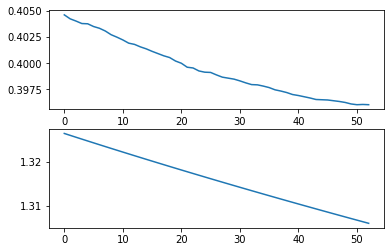

学習データのグラフ


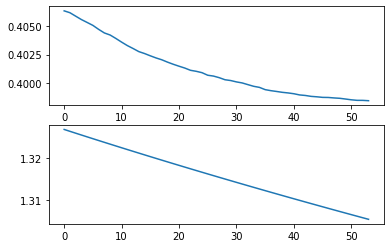

評価データのグラフ


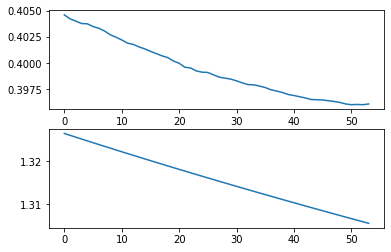

学習データのグラフ


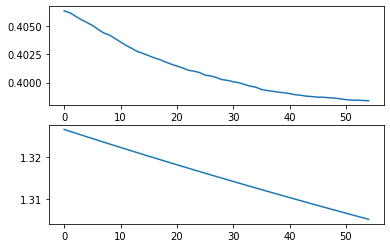

評価データのグラフ


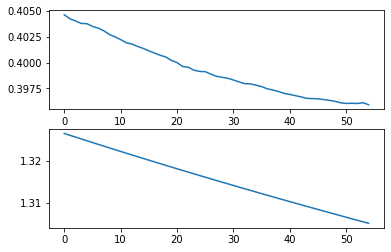

学習データのグラフ


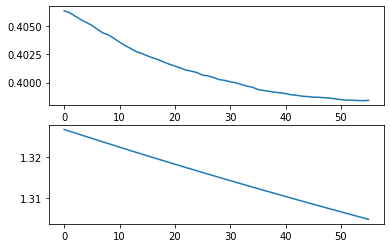

評価データのグラフ


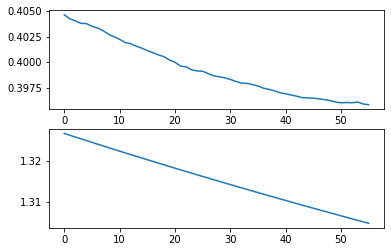

学習データのグラフ


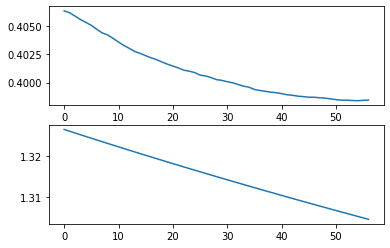

評価データのグラフ


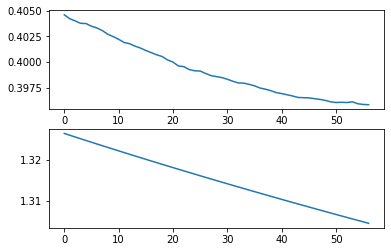

学習データのグラフ


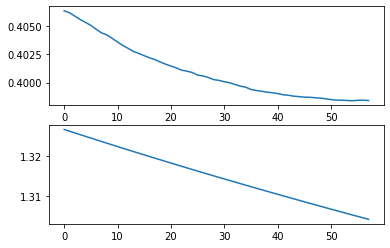

評価データのグラフ


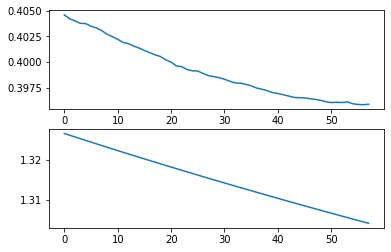

学習データのグラフ


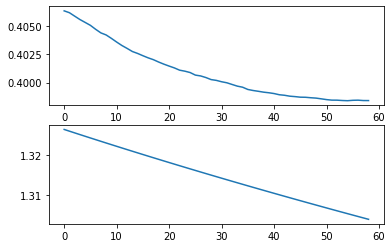

評価データのグラフ


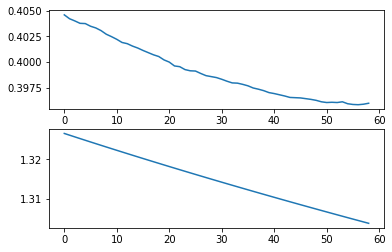

学習データのグラフ


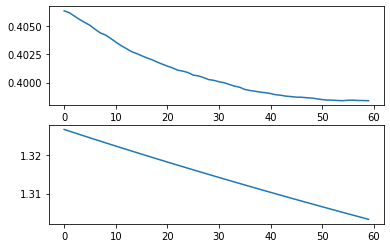

評価データのグラフ


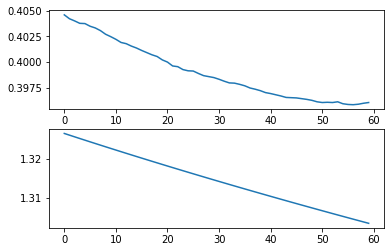

学習データのグラフ


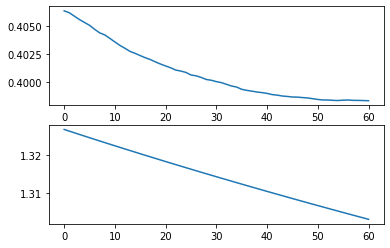

評価データのグラフ


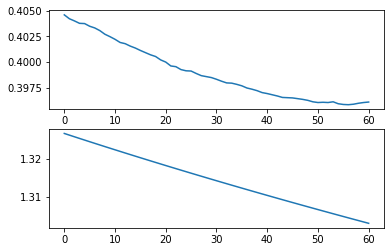

学習データのグラフ


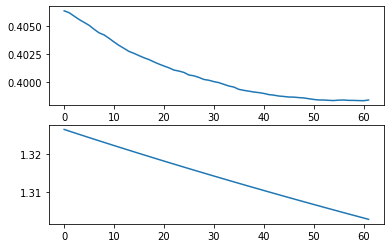

評価データのグラフ


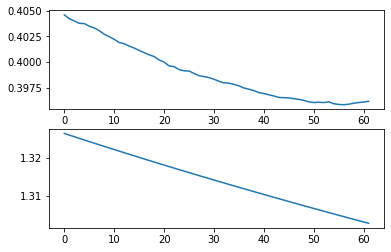

学習データのグラフ


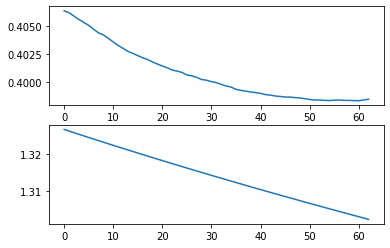

評価データのグラフ


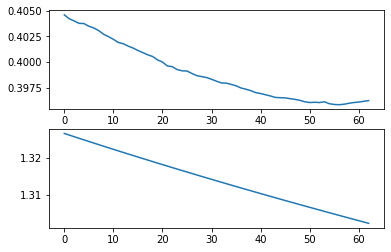

学習データのグラフ


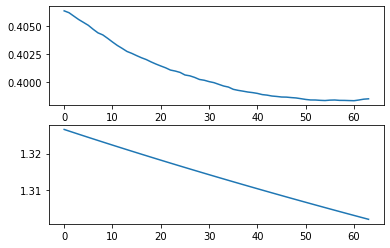

評価データのグラフ


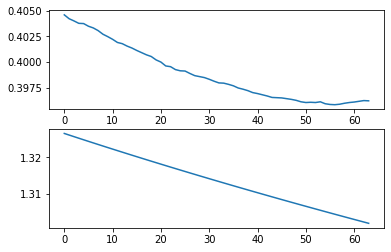

学習データのグラフ


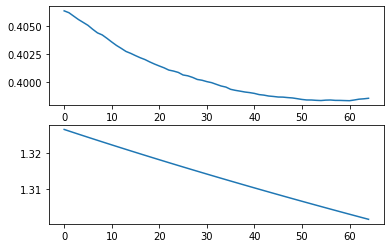

評価データのグラフ


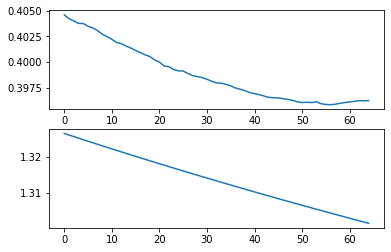

学習データのグラフ


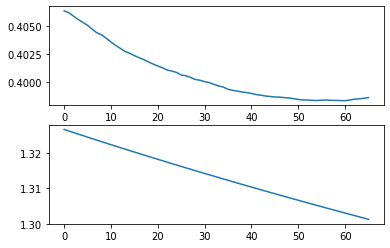

評価データのグラフ


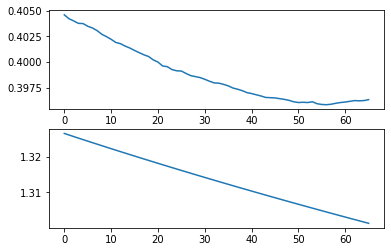

学習データのグラフ


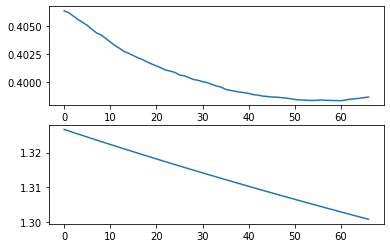

評価データのグラフ


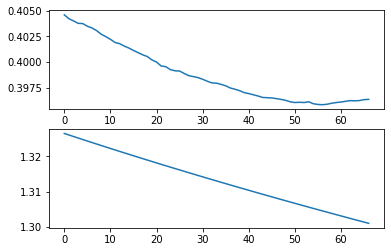

学習データのグラフ


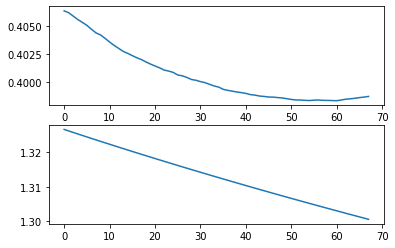

評価データのグラフ


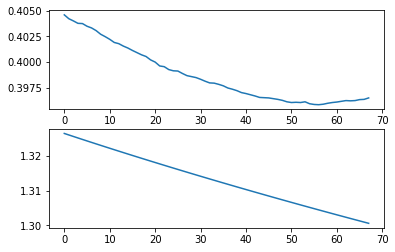

学習データのグラフ


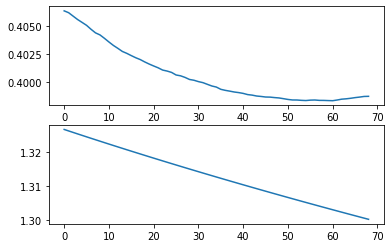

評価データのグラフ


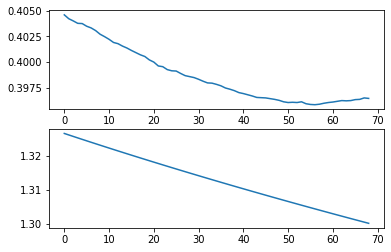

学習データのグラフ


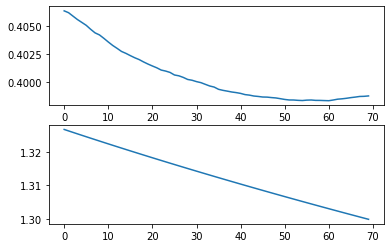

評価データのグラフ


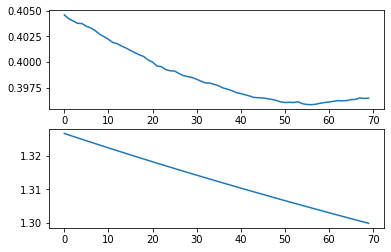

学習データのグラフ


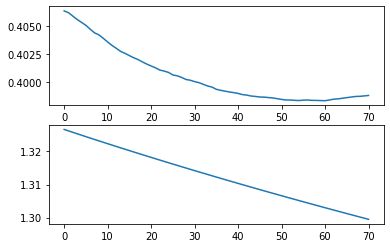

評価データのグラフ


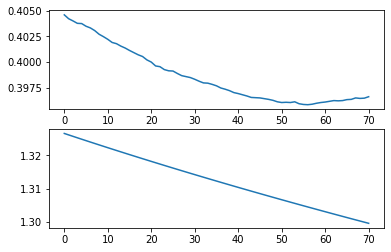

学習データのグラフ


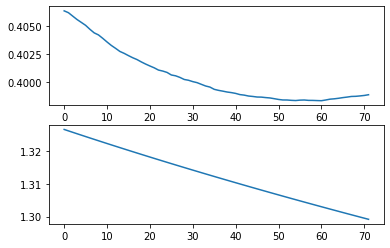

評価データのグラフ


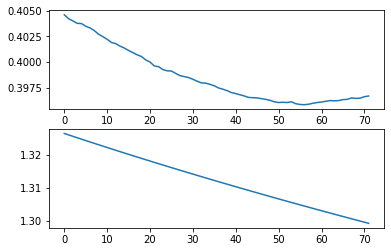

学習データのグラフ


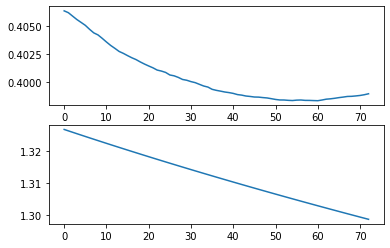

評価データのグラフ


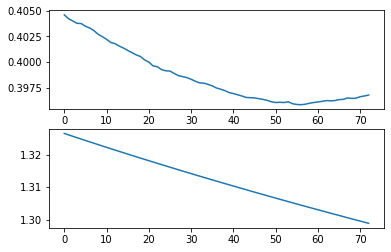

学習データのグラフ


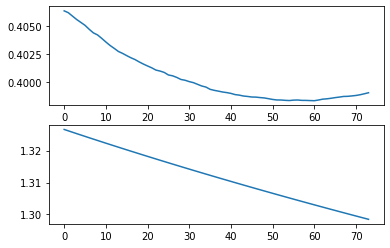

評価データのグラフ


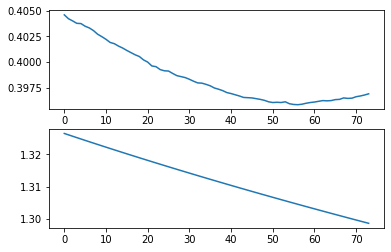

学習データのグラフ


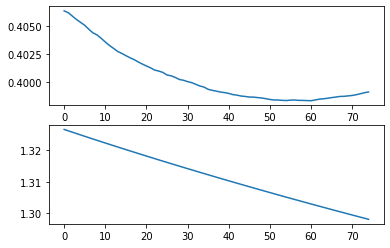

評価データのグラフ


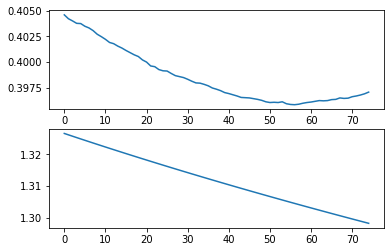

学習データのグラフ


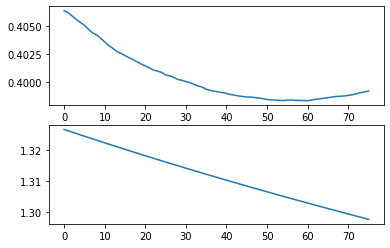

評価データのグラフ


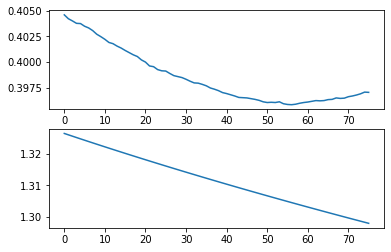

学習データのグラフ


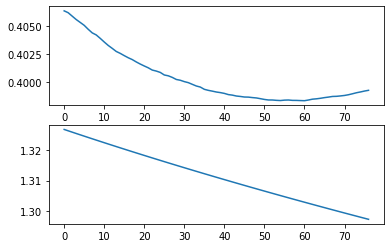

評価データのグラフ


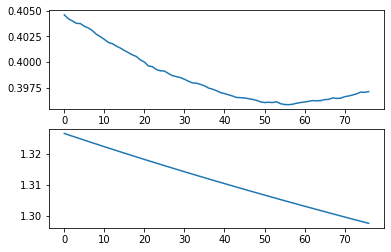

学習データのグラフ


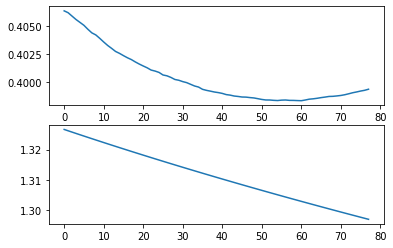

評価データのグラフ


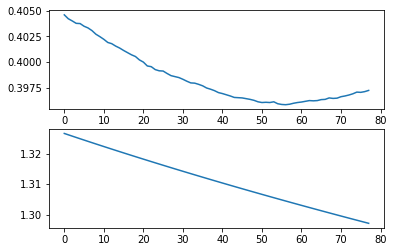

学習データのグラフ


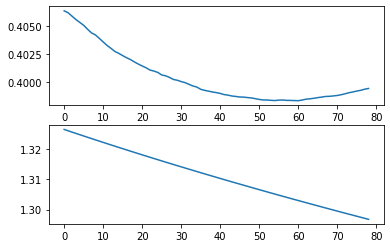

評価データのグラフ


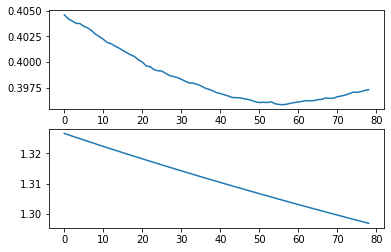

学習データのグラフ


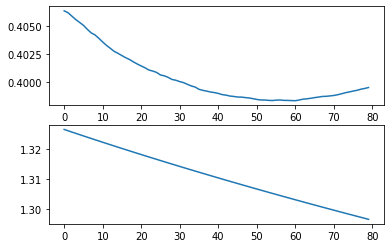

評価データのグラフ


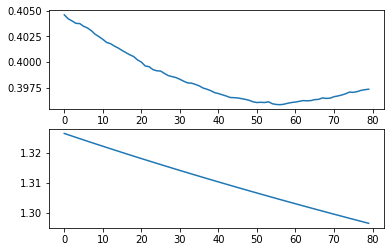

学習データのグラフ


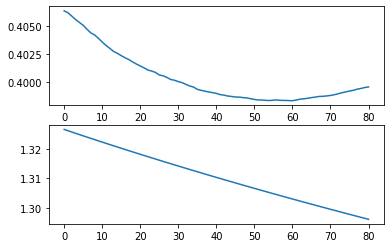

評価データのグラフ


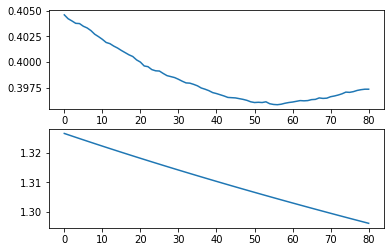

学習データのグラフ


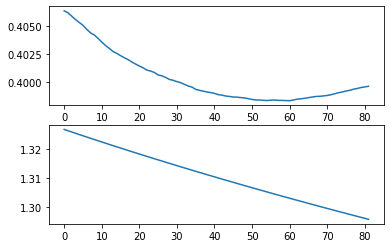

評価データのグラフ


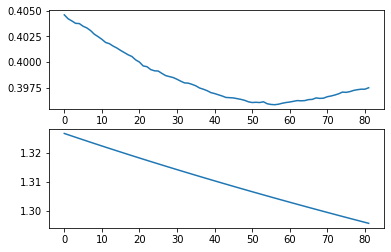

学習データのグラフ


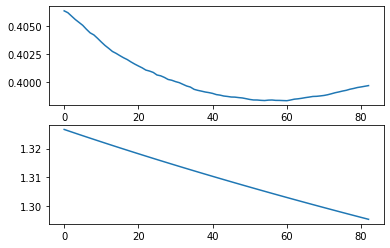

評価データのグラフ


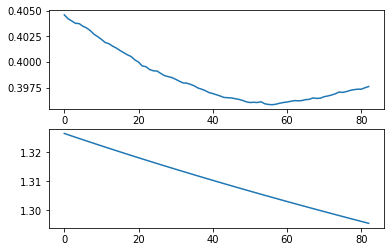

学習データのグラフ


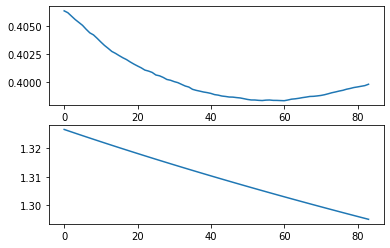

評価データのグラフ


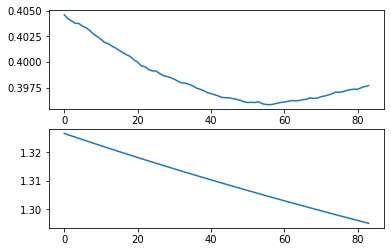

学習データのグラフ


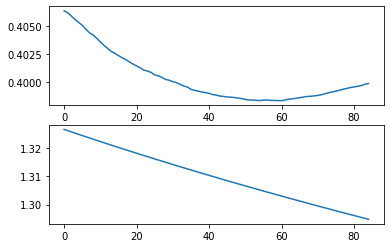

評価データのグラフ


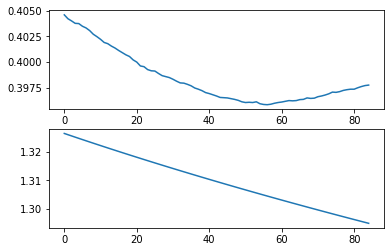

学習データのグラフ


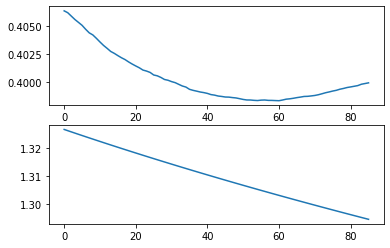

評価データのグラフ


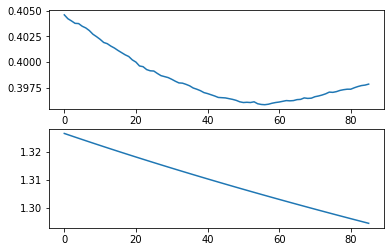

学習データのグラフ


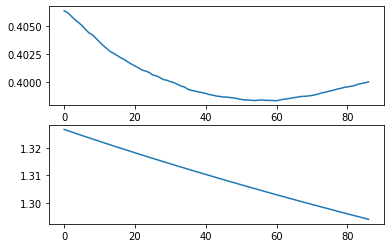

評価データのグラフ


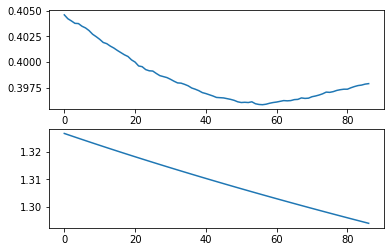

学習データのグラフ


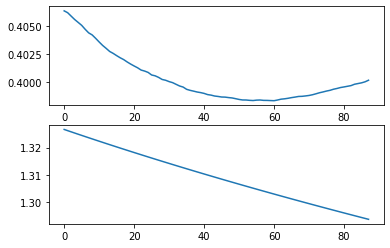

評価データのグラフ


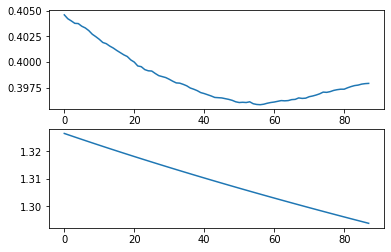

学習データのグラフ


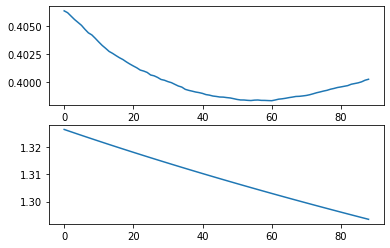

評価データのグラフ


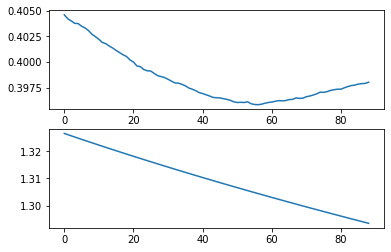

学習データのグラフ


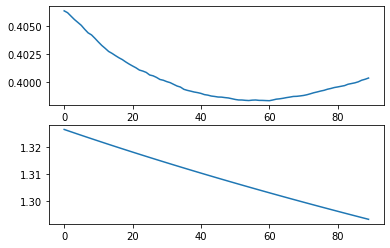

評価データのグラフ


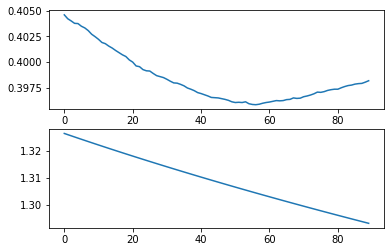

学習データのグラフ


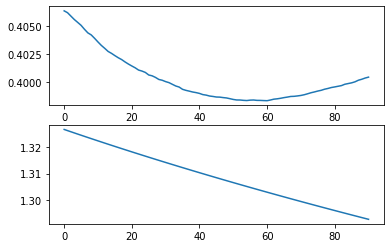

評価データのグラフ


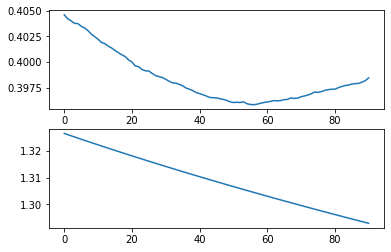

学習データのグラフ


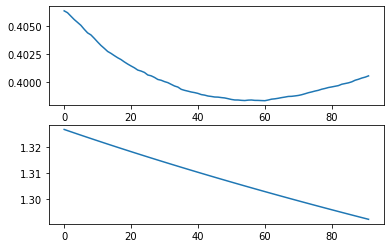

評価データのグラフ


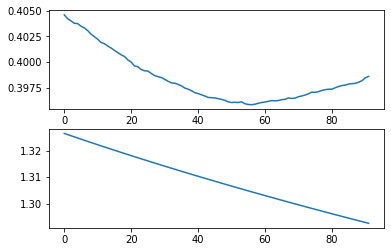

学習データのグラフ


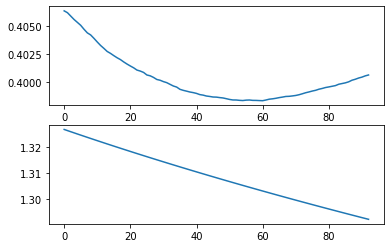

評価データのグラフ


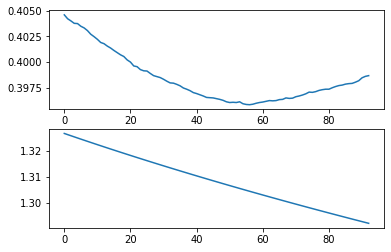

学習データのグラフ


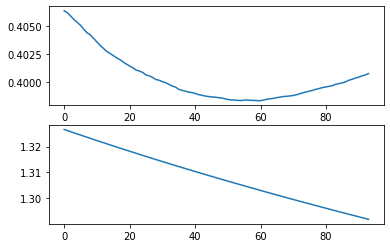

評価データのグラフ


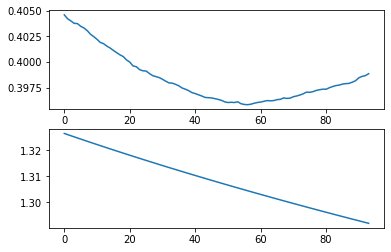

学習データのグラフ


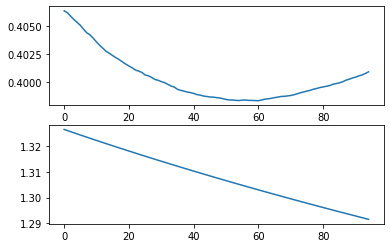

評価データのグラフ


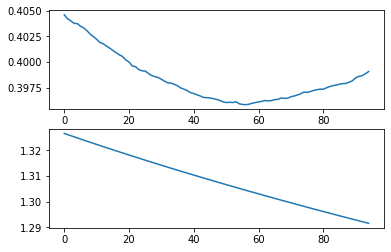

学習データのグラフ


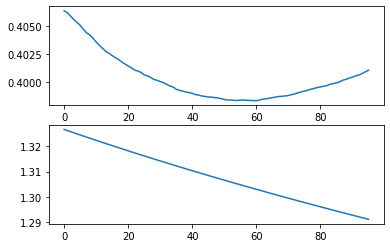

評価データのグラフ


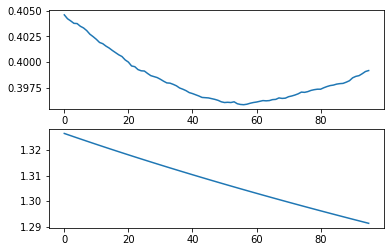

学習データのグラフ


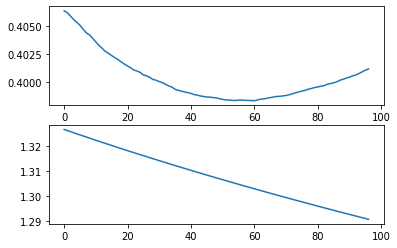

評価データのグラフ


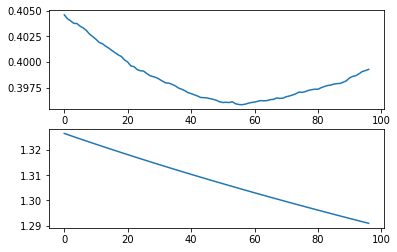

学習データのグラフ


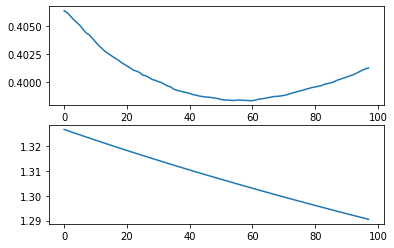

評価データのグラフ


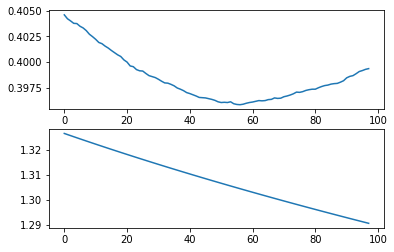

学習データのグラフ


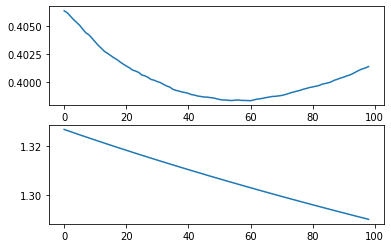

評価データのグラフ


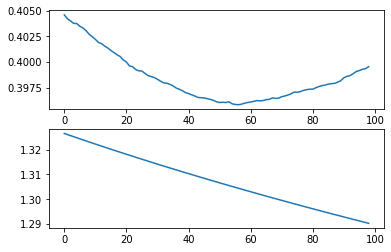

学習データのグラフ


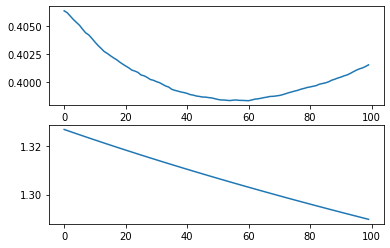

評価データのグラフ


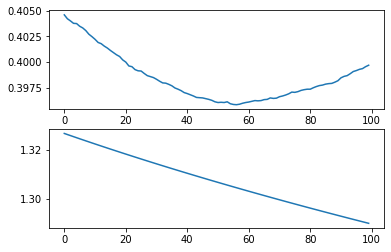

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
max_epoch = 100
x_train_torch = torch.tensor(x_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.int64)
x_val_torch = torch.tensor(x_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.int64)

loses = []
accs = []
val_loses = []
val_accs = []

for epoch in range(max_epoch):

        # データをGPUへ転送
        x = x_train_torch
        t = y_train_torch

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 学習状況の確認
        label = torch.argmax(y, dim=1)
        acc = (label == t).sum() * 1.0 / len(t)
        loses.append(loss.item())
        accs.append(acc)
        print("学習データのグラフ")
        graph_plot(accs, loses, epoch+1)


        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5

        #評価データ
        x_valid = x_val_torch
        t_valid = y_val_torch
        y_valid = net(x_valid)
        val_label = torch.argmax(y_valid, dim=1)  
        val_acc = (val_label == t_valid).sum() * 1.0 / len(t_valid)   

        val_loss = criterion(y_valid, t_valid)
        val_accs.append(val_acc)
        val_loses.append(val_loss.item())
        print("評価データのグラフ")
        graph_plot(val_accs, val_loses, epoch+1)

        if epoch % 20 == 0:
            torch.save(net, "model_76.pth")
            torch.save(optimizer.state_dict(), "opt_76.pth")

In [ ]:
def make_dataset(x,t):
    from torch.utils.data import TensorDataset
    from torch.utils.data import DataLoader

    batch_size = 64
    x = torch.tensor(x, dtype=torch.float32)
    t = torch.tensor(t, dtype=torch.int64)
    dataset = TensorDataset(x, t)   
    dataloader = DataLoader(dataset, batch_size, shuffle=True)

    return dataloader

dataloader_train = make_dataset(x_train, y_train)
dataloader_val = make_dataset(x_val, y_val)
dataloader_test = make_dataset(x_test, y_test)

77

In [ ]:
# ==============================
# PyTorch実装のMLP
# ==============================
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

      # 使用するオブジェクトを定義
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 4)  # 10000層の入力層から1000層の中間層への全結合
    
    # 順伝播
    def forward(self, x):
        y = self.fc1(x)  # xを線形変換（fc1）し、出力yを得る
        return y 

# ネットワークのインスタンスを作成
net = Net()

In [ ]:
# 訓練ループ（エポックごとに検証データの正解率を表示）
def calc_acc(data_loader):

    with torch.no_grad():
        accs = list()
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)

            label = torch.argmax(y, dim=1)
            acc = (label == t).sum() * 1.0 / len(t)
            accs.append(acc)

    return torch.tensor(accs).mean()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
max_epoch = 30

for epoch in range(max_epoch):

    # ミニバッチ学習
    for batch in dataloader_train:

        # バッチサイズ分のサンプルを抽出
        x, t = batch  # 1

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 学習状況の確認
        label = torch.argmax(y, dim=1)
        acc = (label == t).sum() * 1.0 / len(t)
        print("epoch: %d    loss: %.3f    acc: %.3f" % (epoch+1, loss.item(), acc))

        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5

ストリーミング出力は最後の 5000 行に切り捨てられました。
epoch: 30    loss: 0.312    acc: 0.859
epoch: 30    loss: 0.309    acc: 0.906
epoch: 30    loss: 0.522    acc: 0.828
epoch: 30    loss: 0.296    acc: 0.922
epoch: 30    loss: 0.721    acc: 0.766
epoch: 30    loss: 0.586    acc: 0.812
epoch: 30    loss: 0.336    acc: 0.844
epoch: 30    loss: 0.422    acc: 0.844
epoch: 30    loss: 0.583    acc: 0.750
epoch: 30    loss: 0.402    acc: 0.844
epoch: 30    loss: 0.610    acc: 0.797
epoch: 30    loss: 0.471    acc: 0.766
epoch: 30    loss: 0.402    acc: 0.859
epoch: 30    loss: 0.483    acc: 0.781
epoch: 30    loss: 0.474    acc: 0.766
epoch: 30    loss: 0.597    acc: 0.797
epoch: 30    loss: 0.447    acc: 0.828
epoch: 30    loss: 0.384    acc: 0.859
epoch: 30    loss: 0.458    acc: 0.812
epoch: 30    loss: 0.429    acc: 0.859
epoch: 30    loss: 0.501    acc: 0.828
epoch: 30    loss: 0.450    acc: 0.844
epoch: 30    loss: 0.370    acc: 0.906
epoch: 30    loss: 0.370    acc: 0.844
epoch: 30    loss: 0.307    acc:

78

In [ ]:
# 訓練ループ（エポックごとに検証データの正解率を表示）
def calc_acc(data_loader):

    with torch.no_grad():
        accs = list()
        for batch in data_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)

            label = torch.argmax(y, dim=1)
            acc = (label == t).sum() * 1.0 / len(t)
            accs.append(acc)

    return torch.tensor(accs).mean()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
max_epoch = 30
# モデルをGPUへ転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(max_epoch):

    # ミニバッチ学習
    for batch in dataloader_train:

        # バッチサイズ分のサンプルを抽出
        x, t = batch  # 1

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 学習状況の確認
        label = torch.argmax(y, dim=1)
        acc = (label == t).sum() * 1.0 / len(t)
        print("epoch: %d    loss: %.3f    acc: %.3f" % (epoch+1, loss.item(), acc))

        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5
        
    # 検証データの性能を確認
    val_acc = calc_acc(dataloader_val)
    print("epoch: %d    val_acc: %.3f" % (epoch+1, val_acc))

79

In [ ]:
# ==============================
# PyTorch実装のMLP
# ==============================
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

      # 使用するオブジェクトを定義
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(300, 150)  # 10000層の入力層から1000層の中間層への全結合
        self.fc2 = nn.Linear(150, 50)
        self.fc3 = nn.Linear(50, 4)
    
    # 順伝播
    def forward(self, x):
        h = F.relu(self.fc1(x))  # xを線形変換（fc1）し、非線形変換（relu）し、中間表現hを得る
        h1 = F.relu(self.fc2(h))
        y = self.fc3(h1)  # 中間表現hを線形変換（fc4）し、出力yを得る
        return y 

# ネットワークのインスタンスを作成
net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
max_epoch = 30
# モデルをGPUへ転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(max_epoch):

    # ミニバッチ学習
    for batch in dataloader_train:

        # バッチサイズ分のサンプルを抽出
        x, t = batch  # 1

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)  # 2
        loss = criterion(y, t)  # 3

        # 学習状況の確認
        label = torch.argmax(y, dim=1)
        acc = (label == t).sum() * 1.0 / len(t)
        print("epoch: %d    loss: %.3f    acc: %.3f" % (epoch+1, loss.item(), acc))

        # 誤差逆伝播
        loss.backward()  # 4
        optimizer.step()  # 5
        
    # 検証データの性能を確認
    val_acc = calc_acc(dataloader_val)
    print("epoch: %d    val_acc: %.3f" % (epoch+1, val_acc))

ストリーミング出力は最後の 5000 行に切り捨てられました。
epoch: 30    loss: 0.236    acc: 0.938
epoch: 30    loss: 0.428    acc: 0.828
epoch: 30    loss: 0.350    acc: 0.859
epoch: 30    loss: 0.185    acc: 0.938
epoch: 30    loss: 0.125    acc: 0.984
epoch: 30    loss: 0.190    acc: 0.953
epoch: 30    loss: 0.241    acc: 0.906
epoch: 30    loss: 0.177    acc: 0.938
epoch: 30    loss: 0.201    acc: 0.906
epoch: 30    loss: 0.236    acc: 0.891
epoch: 30    loss: 0.242    acc: 0.875
epoch: 30    loss: 0.267    acc: 0.906
epoch: 30    loss: 0.368    acc: 0.891
epoch: 30    loss: 0.431    acc: 0.875
epoch: 30    loss: 0.182    acc: 0.938
epoch: 30    loss: 0.253    acc: 0.906
epoch: 30    loss: 0.247    acc: 0.875
epoch: 30    loss: 0.236    acc: 0.938
epoch: 30    loss: 0.567    acc: 0.859
epoch: 30    loss: 0.293    acc: 0.875
epoch: 30    loss: 0.201    acc: 0.891
epoch: 30    loss: 0.479    acc: 0.812
epoch: 30    loss: 0.278    acc: 0.875
epoch: 30    loss: 0.164    acc: 0.969
epoch: 30    loss: 0.156    acc:

In [ ]:
print("acc: %.3f", calc_acc(dataloader_test))

acc: %.3f tensor(0.8993)
